In [1]:
import nbformat
from IPython.display import display, Markdown

def generate_table_of_contents():
    table_of_contents = []
    for cell in nbformat.read('./numerical_simulation.ipynb', as_version=nbformat.NO_CONVERT).cells:
        if cell.cell_type == 'markdown':
            for line in cell.source.split('\n'):
                if line.startswith('#'):
                    heading_level = len(line.split()[0])
                    heading_text = ' '.join(line.split()[1:]) 
                    table_of_contents.append('  ' * (heading_level - 1) + '- ' + heading_text)
    display(Markdown('\n'.join(table_of_contents)))

generate_table_of_contents()

- **🖥️ Simulation requirements**
  - 📥 Imports
  - 🎛️ Parameters
  - 🔧 Utils
- 🤔 **Context**
  - 🎯 Goal
  - 🔎 Detection methods
  - ➖ Nulling
  - 📡 Projected telescope position
  - 🔆 Signal nature
  - 🏮 MMI
  - 🔀 Recombiner
  - 💠 Kernel
  - 🌡️ Thermo-optic phase shifter
- 💡 **Our approach**
  - 🏗️ Current architecture
  - 🗺️ Transmission maps
- 🪛 **Calibration**
  - 🫳 Manual shift controls
  - 🧬 Genetic algorithm
    - Algorithm
    - Reliability (WIP)
  - 🤖 Machine Learning Approach
    - Dataset generation
    - Model definition (WIP)
    - Model training
  - 🎭 Shifters correlation
- ⚙️ **Data generation**
  - 🟨 Single observation
  - 🟡 Parallactic diversity
- 🔎 **Data analysis**
  - 📊 Output distributions
  - 📢 Noise sensitivity
  - ☑️ Model fitting (WIP)
  - 📈 Test statistics
    - Mean
    - Median
    - Argmax
    - Kolmogorov-Smirnov
    - Cramèr-von Mises
    - Wilcoxon-Mann-Whitney (WIP)
  - ❓ ROC curves
  - 💪 P-values
- 🪐 **Characterization**
  - 🔄️ Angular diversity
  - 🌌 On-sky contribution
  - ♒ Correlation map (WIP)

---

<div align=center>

# **🖥️ Simulation requirements**

</div>

## 📥 Imports

In [2]:
import os
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.origin'] = 'lower'
import astropy.units as u
import astropy.constants as const
import ipywidgets as widgets
from IPython.display import clear_output, display
import sympy as sp
import fitter
import numba as nb
from scipy.optimize import curve_fit
from scipy.ndimage import rotate
from LRFutils import color
import tensorflow as tf

## 🎛️ Parameters

<div align=center>
👉 <i><U>Only edit the following block</u></i>
</div>

In [3]:
# Wavelength
L = 1.65 * u.um

# Telescopes properties
TELESCOPE_POSITIONS = np.array([
    [0, 0],
    [1, 1],
    [2, 1.5],
    [3, 0.7],
]) * 42.2 * u.m
LATITUDE = -24.6275 * u.deg
DECLINATION = -64.71 * u.deg
FOV = 10 * u.mas # Field of view

# Target properties
ALPHA = 70 * u.deg # Parallactic angle
THETA = 7 * u.mas # Angular spearation
CONTRAST = 1e-6
STAR_FLUX = 1e6 * u.photon / u.s # This encapsulate the star magnitude and the telescope collecting area

# Observation conditions
DH = 8 * u.hourangle # Observation duration
DT = 1 * u.s # Exposure time

# Cophasing errors
INPUT_CE_RMS = 100 * u.nm # ~100 nm for ground based telescopes, 10 to 1 nm for space telescopes
SHIFTS_CE_RMS = 100 * u.nm
SHIFTS_CE_OFFSET = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) * u.nm

# SHIFTS_CE_OFFSET = np.array([1.64214688, 1.64216085, 0.00554631, 1.64884721, 1.62784278, 0.03160111, 0.0182902, 0.02791266, 0.01329669, 0.01020052, 1.63187602, 1.64524911, 0.02049508, 0.0165746]) * L.unit
# SHIFTS_CE_RMS = L*0

Processing parameters (conversion to commonly used units)

In [4]:
TELESCOPE_POSITIONS = TELESCOPE_POSITIONS.to(u.m)
ALPHA = ALPHA.to(u.rad)
THETA = THETA.to(u.mas)
LATITUDE = LATITUDE.to(u.deg)
DECLINATION = DECLINATION.to(u.deg)
INPUT_CE_RMS = INPUT_CE_RMS.to(L.unit)
SHIFTS_CE_RMS = SHIFTS_CE_RMS.to(L.unit)
SHIFTS_CE_OFFSET = SHIFTS_CE_OFFSET.to(L.unit)
ALPHA_RANGE = np.linspace(0,2*np.pi,360)*u.rad
EXTENT = (-FOV.value, FOV.value, -FOV.value, FOV.value)

## 🔧 Utils

Numpy `random.normal()` is not jit-able (on flight compilation), so we need to define our own random.normal function

In [5]:
@nb.njit()
def random_normal(scale: float, size: int = 1) -> np.ndarray[float]:
    """Generate an array of random numbers following a normal distribution.
    
    Parameters
    ----------
    - scale: Standard deviation of the normal distribution.
    - size: Number of random numbers to generate.

    Returns
    -------
    - Array of random numbers.
    
    """
    return np.array(
        [
            np.sqrt(-2 * np.log(np.random.rand()))
            * np.cos(2 * np.pi * np.random.rand())
            * scale
            for _ in range(size)
        ]
    )

We only consider relative phases, so we only consider phase shift in `[0,wavelenght[`

In [6]:
@nb.njit()
def bound_phase_njit(phase:float, wavelenght:float=L.value):
    """Bring a phase to the interval [0, wavelenght].

    Parameters
    ----------
    - phase: Phase to bound (in distance unit)
    - wavelenght: Wavelenght of the light (same unit as phase) 

    Returns
    -------
    - Phase in the interval [0, wavelenght]
    """
    return np.mod(phase, wavelenght)

def bound_phase(phase:u.Quantity, wavelenght:u.Quantity=L):
    """Bring a phase to the interval [0, wavelenght].

    Parameters
    ----------
    - phase: Phase to bound
    - wavelenght: Wavelenght of the light

    Returns
    -------
    - Phase in the interval [0, wavelenght]
    """
    return bound_phase_njit(phase.value, wavelenght.to(phase.unit).value) * phase.unit

---

<div align=center>

# 🤔 **Context**

</div>

## 🎯 Goal

We aim to detect make direct detection of exoplanets. There is two main challenges to achieve this goal:
- The **contrast**: the exoplanet is much fainter than the star it orbits. The contrast is typically of the order of $10^{-6}$ to $10^{-10}$.
- The **angular separation**: the exoplanet is very close to the star. The angular separation depend on the distance of the exoplanet to the star and the distance of the star to the observer and can easily goes below the arcsecond.

## 🔎 Detection methods

It exist several methods to detect exoplanets. The most common are:
- **Radial velocity method**: the exoplanet induce a wobble in the star it orbits. This wobble can be detected by the Doppler effect (the light is alternatively redshifted and blueshifted).
- **Transit method**: the exoplanet pass in front of the star and block a fraction of the light. This fraction can be detected by the decrease of the star luminosity.
- **Microlensing**: the exoplanet act as a lens and magnify the light of a background star. This magnification can be detected by the increase of the star luminosity.
- **Astrometry**: the exoplanet induce a wobble in the star it orbits. This wobble can be detected by the change of the star position.
- **Coronography**: the exoplanet is directly imaged. This is the most challenging method because of the contrast and the angular separation.

<div align=center>
<img src="img/detection_methods.jpg" width=500px>
<p><i>Paul Anthony Wilson - Exoplanet detection techniques</i><p>
</div>

Until now, the coronography was the only method allowing direct detection. But it has two main limitations:
- It require huge telescopes in order to have a good angular resolution.
- The contrast we can achieve is limited by unperfect fabrication process of the optical components which lead to undesired diffraction effects.

## ➖ Nulling

This is where the Nulling technic come into play. The idea is to use two several telescopes and take advantage of destructives interferances to cancel the star light and using the fact that the planet is not perfectly in the line of sight, which will lead to an unperfect destructive interference, or in best scenarios, on constructive ones! This is a very challenging technic because it is highly phase sensitive and require a very good control of the optical path.

<div align=center>
<img src="img/nulling_principle.jpg" width=700px>
</div>

In [7]:
@nb.njit()
def nuller_2x2(beams:np.ndarray[complex]) -> np.ndarray[complex]:
    """
    Simulate a 2 input beam nuller.

    Parameters
    ----------
    - beams: Array of 2 input beams complex amplitudes

    Returns
    -------
    - Array of 2 output beams complex amplitudes
        - 1st output is the bright channel
        - 2nd output is the dark channel
    """

    # Nuller matrix
    N = 1/np.sqrt(2) * np.array([
        [1,   1],
        [1,  -1],
    ], dtype=np.complex128)

    # Operation
    return N @ beams

## 📡 Projected telescope position

The interferometry process depend on the projected geometry of the telescope position in the plane perpendicular to the line of sight. For each observation, we will then need to compute these projected positions in order to have the correct baseline lenght (and thus the correct phase shifts).

These projected location can be computed using the following formula $^{1,2}$ :

$$
\begin{pmatrix}
u \\
v
\end{pmatrix}
=
\begin{pmatrix}
- \sin(l) \sin(h) & \cos(h)\\
\sin(l) \cos(h) \sin(\delta) + \cos(l) \cos(\delta) & \sin(h) \sin(\delta)
\end{pmatrix}
\begin{pmatrix}
B_\text{north} \\
B_\text{east}
\end{pmatrix}
$$

with
- $l$ the latitude of the observatory
- $h$ the hour angle
- $\delta$ the declination of the star

Rerefence:
1. Peter Marley Chingaipe et al. - *"High-contrast detection of exoplanets with a kernnel-nuller a the VLTI"*, 2023
2. Ségransan - *"Observability and UV coverage"*, 2007

In [8]:
def get_ut_position():

    # UT coordinates... obtained on Google map 😅
    UTs_coordinates = np.array([
        [-70.4048732988764, -24.627602893919807],
        [-70.40465753243652, -24.627118902835786],
        [-70.40439460074228, -24.62681028261176],
        [-70.40384287956437, -24.627033500373024]
    ]) # ⚠️ Expressed in [longitude, latitude] to easily convert to [x, y]
    
    # We are only interested in the relative positions of the UTs
    # The first UT is the reference
    UTs_coordinates -= UTs_coordinates[0]

    # Altitude of the UTs
    earth_radius = 6_378_137 * u.m
    UTs_elevation = 2_635 * u.m

    # Angle to distance conversion
    return np.tan((UTs_coordinates * u.deg).to(u.rad)) * (earth_radius + UTs_elevation)

TELESCOPE_POSITIONS = get_ut_position()

In [9]:
@nb.njit()
def project_baseline_njit(
    telescope_positions: np.ndarray[float] = TELESCOPE_POSITIONS.value,
    h: float = 0,
    l: float = LATITUDE.to(u.rad).value,
    d: float = DECLINATION.to(u.rad).value,
) -> np.ndarray[float]:
    """
    Rotate the telescope positions by an angle alpha.

    Parameters
    ----------
    - telescope_positions: Telescope positions.
    - h: Hour angle (in radian)
    - l: Latitude (in radian)
    - d: Declination (in radian)

    Returns
    -------
    - Rotated telescope positions (same shape and unit as telescope_positions)
    """

    M = np.array([
        [ -np.sin(l)*np.sin(h),                                np.cos(h)          ],
        [ np.sin(l)*np.cos(h)*np.sin(d) + np.cos(l)*np.cos(d), np.sin(h)*np.sin(d)],
    ])

    projected_telescope_positions = np.empty_like(telescope_positions)
    for i in range(telescope_positions.shape[0]):
        projected_telescope_positions[i] = M @ np.array([telescope_positions[i][1], telescope_positions[i][0]])

    return projected_telescope_positions

def project_baseline(
    telescope_positions: u.Quantity = TELESCOPE_POSITIONS,
    h: u.Quantity = 0*u.hourangle,
    l: u.Quantity = LATITUDE,
    d: u.Quantity = DECLINATION,
) -> u.Quantity:
    """
    Rotate the telescope positions by an angle alpha.

    Parameters
    ----------
    - telescope_positions: Array of telescope positions.
    - h: Hour angle
    - l: Latitude
    - d: Declination

    Returns
    -------
    - Array of rotated telescope positions (same shape and unit as telescope_positions)
    """

    return project_baseline_njit(
            telescope_positions.value,
            h.to(u.rad),
            l.to(u.rad),
            d.to(u.rad),
    ) * telescope_positions.unit

PROJECTED_TELESCOPE_POSITIONS = project_baseline()

In [10]:
def plot_telescope_positions():
    
    h_range = np.linspace(-4,4,15) * 2*np.pi / 24 * u.rad

    latitude_slider = widgets.FloatSlider(
        value=LATITUDE.to(u.deg).value,
        min=-90,
        max=90,
        step=0.01,
        description='Latitude:',
    )

    declination_slider = widgets.FloatSlider(
        value=DECLINATION.to(u.deg).value,
        min=-90,
        max=90,
        step=0.01,
        description='Declination:',
    )

    reset = widgets.Button(description="Reset to defalut")

    plot = widgets.Image(width=500,height=500)

    def update_plot(*args):
    
        _, ax = plt.subplots()

        for i, h in enumerate(h_range):
            UT1, UT2, UT3, UT4 = project_baseline(TELESCOPE_POSITIONS, h, latitude_slider.value*u.deg, declination_slider.value*u.deg)

            ax.scatter(UT1[0], UT1[1], label="UT1" if i==len(h_range)-1 else None, color="C0", s=1+14*i/len(h_range))
            ax.scatter(UT2[0], UT2[1], label="UT2" if i==len(h_range)-1 else None, color="C1", s=1+14*i/len(h_range))
            ax.scatter(UT3[0], UT3[1], label="UT3" if i==len(h_range)-1 else None, color="C2", s=1+14*i/len(h_range))
            ax.scatter(UT4[0], UT4[1], label="UT4" if i==len(h_range)-1 else None, color="C3", s=1+14*i/len(h_range))

        UT1, UT2, UT3, UT4 = project_baseline(TELESCOPE_POSITIONS, 0*u.hourangle, latitude_slider.value*u.deg, declination_slider.value*u.deg)
        ax.scatter(UT2[0], UT2[1], color="black", marker="+")
        ax.scatter(UT3[0], UT3[1], color="black", marker="+")
        ax.scatter(UT4[0], UT4[1], color="black", marker="+")

        ax.set_aspect("equal")
        ax.set_xlabel(f"x [{UT1.unit}]")
        ax.set_ylabel(f"y [{UT1.unit}]")
        ax.set_title(f"Projected telescope positions over the time")
        plt.legend()
        buffer = BytesIO()
        plt.savefig(buffer,format='png')
        plt.close()
        plot.value = buffer.getvalue()

    def reset_values(*args):
        latitude_slider.value = LATITUDE.to(u.deg).value
        declination_slider.value = DECLINATION.to(u.deg).value

    reset.on_click(reset_values)
    latitude_slider.observe(update_plot, 'value')
    declination_slider.observe(update_plot, 'value')
    display(widgets.VBox([latitude_slider, declination_slider, plot, reset]))
    update_plot()
    return

plot_telescope_positions()

## 🔆 Signal nature

The star and the planet are point sources. Seen from a classical telescope, it will result in an image made of the objects convolution with the point spread function (PSF) of the telescope.

$$
I = O \otimes PSF
$$

Here we consider the most simple PSF : the Airy disk. The Airy disk is the diffraction pattern of a point source by a circular aperture. It is given by:

$$
PSF = \left(\frac{2J_1(x)}{x}\right)^2
$$

where $J_1$ is the Bessel function of the first kind of order 1 and $x = \frac{2\pi r}{\lambda f}$ is the normalized radius of the Airy disk.

Then, we focus the image in a monomode optical fiber which will basically only keep the main lobe of the PSF and reshape it in a Gaussian form. In this process, we lose the spatial information so we have no longer images, but the light flux of each object in the fiber can be simply described by a complex number.

Using this formalism, the light flux of the star and the planet can  be described by only 2 complex numbers for each telescope, giving the amplitude and phase of each object.

In [11]:
@nb.njit()
def acquire_signals_njit(
    amplitude: complex,
    angular_separation: float = THETA.to(u.rad).value,
    alpha: float = ALPHA.to(u.rad).value,
    wavelenght: float = L.to(u.m).value,
    projected_telescope_positions: np.ndarray[float] = PROJECTED_TELESCOPE_POSITIONS.to(u.m).value,
) -> np.ndarray[complex]:
    """
    Acquire signals according to the telescope positions.

    Parameters
    ----------
    - amplitude: Light complexe amplitude.
    - angular_separation: Angular separation (in radian).
    - alpha: Parallactic angle (in radian).
    - wavelenght: Wavelength (in meter).
    - telescope_positions: Projected telescope positions (in meter).

    Returns
    -------
    - Acquired signals (complex amplitudes).
    """

    acquired_signals = np.empty(projected_telescope_positions.shape[0], dtype=np.complex128)

    # Rotare the projected telescope positions by the parallactic angle
    rotated_projected_telescope_position = np.empty_like(projected_telescope_positions)
    for i, t in enumerate(projected_telescope_positions):
        rotated_projected_telescope_position[i,0] = t[0] * np.cos(-alpha)
        rotated_projected_telescope_position[i,1] = t[1] * np.sin(-alpha)

    # Acquire the signals according to the angular separation
    for i, p in enumerate(rotated_projected_telescope_position):
        introduced_phase = 2 * np.pi * p[0] * np.sin(angular_separation) / wavelenght
        acquired_signals[i] = amplitude * np.exp(1j * introduced_phase)

    return acquired_signals / np.sqrt(rotated_projected_telescope_position.shape[0])

def acquire_signals(
    amplitude: complex,
    angular_separation: u.Quantity = THETA,
    alpha: u.Quantity = ALPHA,
    wavelenght: u.Quantity = L,
    projected_telescope_positions: u.Quantity = PROJECTED_TELESCOPE_POSITIONS,
) -> np.ndarray[complex]:
    """
    Acquire signals according to the telescope positions.

    Parameters
    ----------
    - amplitude: Light complexe amplitude.
    - angular_separation: Angular separation.
    - alpha: Parallactic angle.
    - wavelenght: Wavelength.
    - projected_telescope_positions: Projected telescope positions.

    Returns
    -------
    - Array of acquired signals (complex amplitudes).
    """

    return acquire_signals_njit(
        amplitude,
        angular_separation.to(u.rad).value,
        alpha.to(u.rad).value,
        wavelenght.to(u.m).value,
        projected_telescope_positions.to(u.m).value,
    )

Represent a complex amplitude as a string

In [12]:
def signals_as_str(signals: np.ndarray[complex]) -> str:
    """
    Convert signals to a string.

    Parameters
    ----------
    - signals : Signals to convert.

    Returns
    -------
    - String representation of the signals.
    """

    res = ""
    for i, s in enumerate(signals):
        res += f" - Telescope {i}:   {np.abs(s):.2e} *exp(i* {np.angle(s)/np.pi:.2f} *pi)   ->   {np.abs(s)**2:.2e}\n"
    return res[:-1]

Define the rest of the constants used in the simulation

In [13]:
STAR_LIGHT = 1+0j
PLANET_LIGHT = STAR_LIGHT * np.sqrt(CONTRAST)

STAR_SIGNALS = acquire_signals(amplitude=STAR_LIGHT, angular_separation=0*u.mas)
PLANET_SIGNALS = acquire_signals(amplitude=PLANET_LIGHT, angular_separation=THETA)

SHIFTS_TOTAL_OPD = bound_phase_njit(SHIFTS_CE_OFFSET.value + random_normal(SHIFTS_CE_RMS.value, size=14), L.value) * L.unit

IDEAL_SHIFTS = bound_phase(-SHIFTS_TOTAL_OPD, L)

print(f"Star signals:\n{signals_as_str(STAR_SIGNALS)}")
print(f"Planet signals:\n{signals_as_str(PLANET_SIGNALS)}")

Star signals:
 - Telescope 0:   5.00e-01 *exp(i* 0.00 *pi)   ->   2.50e-01
 - Telescope 1:   5.00e-01 *exp(i* 0.00 *pi)   ->   2.50e-01
 - Telescope 2:   5.00e-01 *exp(i* 0.00 *pi)   ->   2.50e-01
 - Telescope 3:   5.00e-01 *exp(i* 0.00 *pi)   ->   2.50e-01
Planet signals:
 - Telescope 0:   5.00e-04 *exp(i* 0.00 *pi)   ->   2.50e-07
 - Telescope 1:   5.00e-04 *exp(i* 0.34 *pi)   ->   2.50e-07
 - Telescope 2:   5.00e-04 *exp(i* 0.75 *pi)   ->   2.50e-07
 - Telescope 3:   5.00e-04 *exp(i* -0.39 *pi)   ->   2.50e-07


## 🏮 MMI

The nulling operation is made using Multi Mode Interferometer (MMI). It consist in a multimode waveguide taking several monomode fibers as input and output. The multimode waveguide is shaped in order to produce a specific interference operation, such as spreading the light of an input on all the output, or opposite, gathering the light of all the input on a single output.

To design a simple nuller, we then need a 2x2 MMI that gather (ie. create a constructive interference) all the input light on a single output. The other output is then a "nulled" output, where there is actually all the inputs light but in phase opposition, resulting in a destructive interference.

<div align=center>
<img src="img/mmi.png" width=400px>

*Numerical simulation of a 3x3 gathering MMI - Cvetojevic et. al.: 3-beam Kernel nuller (2022)*

</div>

## 🔀 Recombiner

The recombiner is also an MMI that will place the signals in phase quadrature. A particularity is that the output of the recombiner contain a symmetry. We will take advantage of this in the Kernel step.

<div align=center>
<img src="img/recombiner.png" width=500px>

*Action of a 2x2 recombiner MMI, taking 2 different combination of 4 nulled signals as input - Romain Laugier et al.: Kernel nullers for an arbitrary number of apertures (2020)*

</div>

In [14]:
@nb.njit()
def splitmix_2x2(beams:np.array) -> np.array:
    """
    Simulate a 2 input beam split and mix.

    Parameters
    ----------
    - beams: Array of 2 input beams complex amplitudes

    Returns
    -------
    - Array of 2 output beams complex amplitudes
    """

    theta:float=np.pi/2

    # Splitter matrix
    S = 1/np.sqrt(2) * np.array([
        [np.exp(1j*theta/2), np.exp(-1j*theta/2)],
        [np.exp(-1j*theta/2), np.exp(1j*theta/2)]
    ])

    # Operation
    return S @ beams

## 💠 Kernel

The idea of the kernel is to acquire and substract the pairs of recombined output. As these pairs share symmetrical properties, this substraction will cancel the star light even with first order phase aberations while keeping the planet light!

Moreover, it modify the nuller response (see transmission maps below) in an asymetric way which is interesting for us as it gives us more information to constrain the planet position.

Demonstration:

In [15]:
def demonstration():

    # Elements definition
    I = sp.IndexedBase("I", real=True)  # Kernel intensity
    E = sp.IndexedBase("E")  # Electric field
    A = sp.IndexedBase("A", real=True)  # Amplitude
    P = sp.IndexedBase("phi", real=True)  # Relative phase
    T = sp.IndexedBase("theta", real=True)  # Phase perturbation
    a = sp.symbols("a", cls=sp.Idx)  # First dark
    b = sp.symbols("b", cls=sp.Idx)  # Second dark
    s = sp.symbols("s", cls=sp.Idx)  # Star index
    p = sp.symbols("p", cls=sp.Idx)  # Planet index

    # Intensity in a dark output is the sum of the intensities coming from the star and from the planet
    Ia = I[a, s] + I[a, p]
    Ib = I[b, s] + I[b, p]
    print("Input intensities:")
    display(Ia, Ib)

    # Developping Intensities as interference of the electrical fields
    Ias = abs(E[1, s] + E[2, s] + E[3, s] + E[4, s]) ** 2
    Iap = abs(E[1, p] + E[2, p] + E[3, p] + E[4, p]) ** 2
    Ibs = abs(E[1, s] + E[2, s] + E[3, s] + E[4, s]) ** 2
    Ibp = abs(E[1, p] + E[2, p] + E[3, p] + E[4, p]) ** 2

    Ia = Ia.subs(I[a, s], Ias).subs(I[a, p], Iap)
    Ib = Ia.subs(I[b, s], Ibs).subs(I[b, p], Ibp)
    print("Fields contributions:")
    display(Ia, Ib)

    # Expressing the electric fields as a function of the amplitudes and the relative phases
    E1s = A[s]
    E2s = A[s] * (1 + sp.I * T[2])
    E3s = A[s] * (1 + sp.I * T[3])
    E4s = A[s] * (1 + sp.I * T[4])
    E1p = A[p] * sp.exp(sp.I * P[1])
    E2p = A[p] * sp.exp(sp.I * P[2]) * (1 + sp.I * T[2])
    E3p = A[p] * sp.exp(sp.I * P[3]) * (1 + sp.I * T[3])
    E4p = A[p] * sp.exp(sp.I * P[4]) * (1 + sp.I * T[4])

    # Relative phase : E1 -> 0, E2 -> pi, E3 -> pi/2, E4 -> -pi/2
    Ia = (
        Ia.subs(E[1, s], E1s)
        .subs(E[2, s], -E2s)
        .subs(E[3, s], sp.I * E3s)
        .subs(E[4, s], -sp.I * E4s)
    )
    Ia = (
        Ia.subs(E[1, p], E1p)
        .subs(E[2, p], -E2p)
        .subs(E[3, p], sp.I * E3p)
        .subs(E[4, p], -sp.I * E4p)
    )
    # Relative phase : E1 -> 0, E2 -> pi, E3 -> -pi/2, E4 -> pi/2
    Ib = (
        Ib.subs(E[1, p], E1p)
        .subs(E[2, p], -E2p)
        .subs(E[3, p], -sp.I * E3p)
        .subs(E[4, p], sp.I * E4p)
    )
    Ib = (
        Ib.subs(E[1, s], E1s)
        .subs(E[2, s], -E2s)
        .subs(E[3, s], -sp.I * E3s)
        .subs(E[4, s], sp.I * E4s)
    )
    print("Decomposition in amplitudes and phases:")
    display(Ia.expand().simplify(), Ib.expand().simplify())

    # Kernel intensity
    Ik = Ia - Ib
    print("Difference between the signals")
    display(Ik.expand().simplify())

# demonstration()

## 🌡️ Thermo-optic phase shifter

In practice, we are often limited by the fabrication process of the optical components. The imperfections can lead into phase aberations that will degrade the Kernel-Nuller performance. An attempt to correct these aberations consist in using thermo-optic phase shifters. It consist in a waveguide with a heater that will modify the refractive index of the waveguide and thus the phase of the light passing through it.

As the size of the waveguide is very small, the thermal inertia is very low and the phase can be modified very quickly, in a milisecond time scale. This is a very interesting solution to correct phase aberations, even in real time if we encounter variable phase aberation sources.

<div align=center>
<img src="img/thermo-optic_phase_shifter.png" width=500px>
</div>

In [16]:
@nb.njit()
def phase_shift_njit(
    beam: complex | np.ndarray[complex],
    phase: float | np.ndarray[float],
    wavelenght: float = L.value,
) -> complex | np.ndarray[complex]:
    """
    De-phase the input beam by heating the fiber with an electrical current.

    Parameters
    ----------
    - beam: input beam complex amplitude
    - phase: phase to add (in same unit as wavelenght)
    - wavelenght: wavelength

    Returns
    -------
    - Output beam complex amplitude
    """
    return beam * np.exp(1j * 2 * np.pi * phase / wavelenght)


def phase_shift(
    beam: complex | np.ndarray[complex], phase: u.Quantity, wavelenght: u.Quantity = L
) -> complex | np.ndarray[complex]:
    """
    De-phase the input beam by heating the fiber with an electrical current.

    Parameters
    ----------
    - beam: input beam complex amplitude
    - phase: phase to add
    - wavelenght: wavelength

    Returns
    -------
    - Output beam complex amplitude
    """
    return phase_shift_njit(beam, phase.to(wavelenght.unit).value, wavelenght.value)

---

<div align=center>

# 💡 **Our approach**

</div>

## 🏗️ Current architecture

To implement the 4 telescope tunable Kernel-Nuller, we splitted the 4x4 MMI into series of 2x2 MMI separated by phase shifters.

<div align=center>
<img src="img/scheme.png" width=1000px>

*Architecture of our Kernel-Nuller. N suqares are the 2x2 nullers, S squares are the 2x2 recombiners and P rectangles are the phase shifters*

</div>

In [17]:
@nb.njit()
def kn_njit(
    beams: np.ndarray[complex],
    shifts: np.ndarray[float] = np.zeros(14),
    shifts_total_opd: np.ndarray[float] = SHIFTS_TOTAL_OPD.to(L.unit).value,
    wavelenght: float = L.value,
) -> tuple[np.ndarray[float], np.ndarray[float], np.ndarray[float], float]:
    """
    Simulate a 4 telescope Kernel-Nuller propagation using a numeric approach

    Parameters
    ----------
    - beams: Array of 4 input beams complex amplitudes
    - shifts: Array of 14 injected OPD (in wavelenght unit)
    - shifts_total_opd: Array of 14 intrasic OPD (in wavelenght unit)
    - wavelenght: Wavelength of the light

    Returns
    -------
    - Array of 3 null outputs intensities
    - Array of 6 dark outputs intensities
    - Array of 3 kernels intensities
    - Bright output intensity
    """

    shifts = bound_phase_njit(shifts + shifts_total_opd, wavelenght)

    # First layer of pahse shifters
    nuller_inputs = phase_shift_njit(beams, shifts[:4], wavelenght)

    # First layer of nulling
    N1 = nuller_2x2(nuller_inputs[:2])
    N2 = nuller_2x2(nuller_inputs[2:])

    # Second layer of phase shifters
    N1_shifted = phase_shift_njit(N1, shifts[4:6], wavelenght)
    N2_shifted = phase_shift_njit(N2, shifts[6:8], wavelenght)

    # Second layer of nulling
    N3 = nuller_2x2(np.array([N1_shifted[0], N2_shifted[0]]))
    N4 = nuller_2x2(np.array([N1_shifted[1], N2_shifted[1]]))

    nulls = np.array([N3[1], N4[0], N4[1]], dtype=np.complex128)
    bright = N3[0]

    # Beam splitting
    S_inputs = np.array([N3[1], N3[1], N4[0], N4[0], N4[1], N4[1]]) * 1 / np.sqrt(2)

    # Last layer of phase shifters
    S_inputs = phase_shift_njit(S_inputs, shifts[8:], wavelenght)

    # Beam mixing
    S1_output = splitmix_2x2(np.array([S_inputs[0], S_inputs[2]]))
    S2_output = splitmix_2x2(np.array([S_inputs[1], S_inputs[4]]))
    S3_output = splitmix_2x2(np.array([S_inputs[3], S_inputs[5]]))

    darks = np.array(
        [
            S1_output[0],
            S1_output[1],
            S2_output[0],
            S2_output[1],
            S3_output[0],
            S3_output[1],
        ],
        dtype=np.complex128,
    )

    kernels = np.array(
        [np.abs(darks[2 * i]) ** 2 - np.abs(darks[2 * i + 1]) ** 2 for i in range(3)]
    )

    return nulls, darks, kernels, bright

def kn(
    beams: np.ndarray[complex],
    shifts: u.Quantity = np.zeros(14) * L.unit,
    shifts_total_opd: u.Quantity = SHIFTS_TOTAL_OPD,
    wavelenght: u.Quantity = L
) -> tuple[np.ndarray[float], np.ndarray[float], np.ndarray[float], float]:
    """
    Simulate a 4 telescope Kernel-Nuller propagation using a numeric approach

    Parameters
    ----------
    - beams: Array of 4 input beams complex amplitudes
    - shifts: Array of 14 injected OPD
    - shifts_total_opd: Array of 14 intrasic OPD
    - wavelenght: Wavelength of the light

    Returns
    -------
    - Array of 3 null outputs intensities
    - Array of 6 dark outputs intensities
    - Array of 3 kernels intensities
    - Bright output intensity
    """

    return kn_njit(
        beams,
        shifts.to(wavelenght.unit).value,
        shifts_total_opd.to(wavelenght.unit).value,
        wavelenght.value
    )

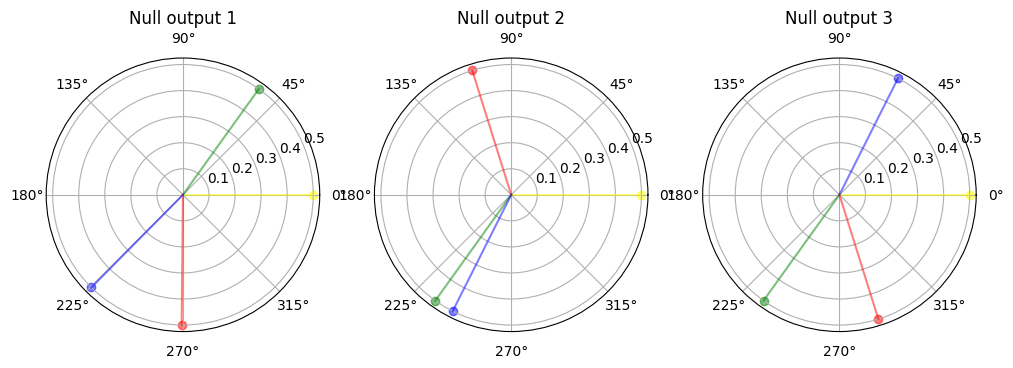

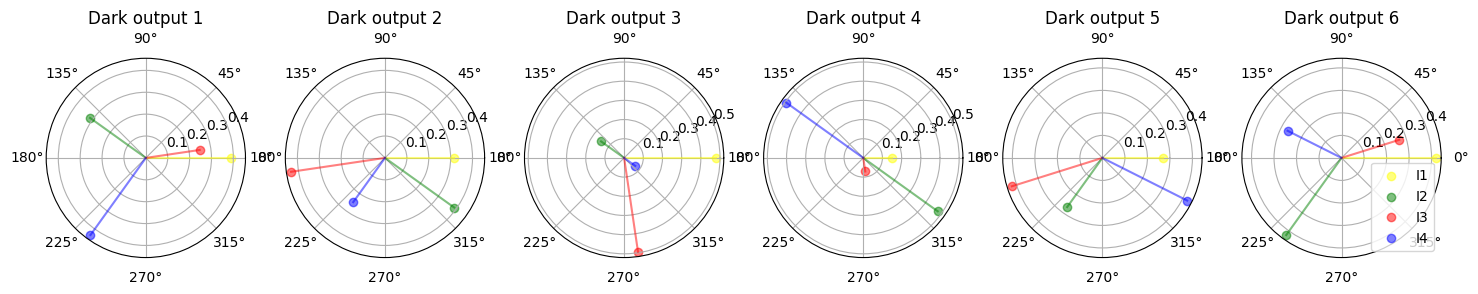

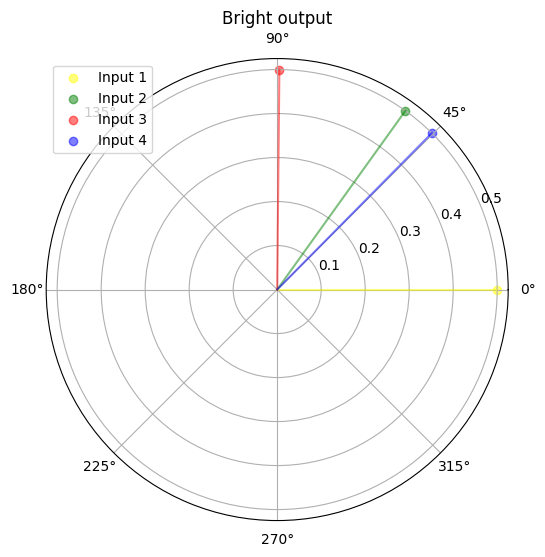

In [18]:
def plot_kn_phase_effect(shifts=None, plot=True):

    if shifts is None:
        shifts = np.zeros(14) * L.unit

    input1_signal = np.array([1+0j, 0, 0, 0])
    input2_signal = np.array([0, 1+0j, 0, 0])
    input3_signal = np.array([0, 0, 1+0j, 0])
    input4_signal = np.array([0, 0, 0, 1+0j])

    nulls1, darks1, _, bright1 = kn(input1_signal, shifts)
    nulls2, darks2, _, bright2 = kn(input2_signal, shifts)
    nulls3, darks3, _, bright3 = kn(input3_signal, shifts)
    nulls4, darks4, _, bright4 = kn(input4_signal, shifts)

    # Using first signal as reference
    nulls2 = np.abs(nulls2) * np.exp(1j * (np.angle(nulls2) - np.angle(nulls1)))
    nulls3 = np.abs(nulls3) * np.exp(1j * (np.angle(nulls3) - np.angle(nulls1)))
    nulls4 = np.abs(nulls4) * np.exp(1j * (np.angle(nulls4) - np.angle(nulls1)))
    darks2 = np.abs(darks2) * np.exp(1j * (np.angle(darks2) - np.angle(darks1)))
    darks3 = np.abs(darks3) * np.exp(1j * (np.angle(darks3) - np.angle(darks1)))
    darks4 = np.abs(darks4) * np.exp(1j * (np.angle(darks4) - np.angle(darks1)))
    bright2 = np.abs(bright2) * np.exp(1j * (np.angle(bright2) - np.angle(bright1)))
    bright3 = np.abs(bright3) * np.exp(1j * (np.angle(bright3) - np.angle(bright1)))
    bright4 = np.abs(bright4) * np.exp(1j * (np.angle(bright4) - np.angle(bright1)))
    nulls1 = np.abs(nulls1) * np.exp(1j * 0)
    darks1 = np.abs(darks1) * np.exp(1j * 0)
    bright1 = np.abs(bright1) * np.exp(1j * 0)

    # Null outputs
    _, axs = plt.subplots(1, 3, figsize=(12, 12), subplot_kw={'projection': 'polar'})
    for null in range(3):
        axs[null].scatter(np.angle(nulls1[null]), np.abs(nulls1[null]), color="yellow", label='Input 1', alpha=0.5)
        axs[null].plot([0, np.angle(nulls1[null])], [0, np.abs(nulls1[null])], color="yellow", alpha=0.5)
        axs[null].scatter(np.angle(nulls2[null]), np.abs(nulls2[null]), color="green", label='Input 2', alpha=0.5)
        axs[null].plot([0, np.angle(nulls2[null])], [0, np.abs(nulls2[null])], color="green", alpha=0.5)
        axs[null].scatter(np.angle(nulls3[null]), np.abs(nulls3[null]), color="red", label='Input 3', alpha=0.5)
        axs[null].plot([0, np.angle(nulls3[null])], [0, np.abs(nulls3[null])], color="red", alpha=0.5)
        axs[null].scatter(np.angle(nulls4[null]), np.abs(nulls4[null]), color="blue", label='Input 4', alpha=0.5)
        axs[null].plot([0, np.angle(nulls4[null])], [0, np.abs(nulls4[null])], color="blue", alpha=0.5)
        axs[null].set_title(f'Null output {null+1}')

    if not plot:
        null_plot = BytesIO()
        plt.savefig(null_plot, format='png')
        plt.close()

    # Dark outputs
    _, axs = plt.subplots(1, 6, figsize=(18, 12), subplot_kw={'projection': 'polar'})
    for dark in range(6):
        axs[dark].scatter(np.angle(darks1[dark]), np.abs(darks1[dark]), color="yellow", label='I1', alpha=0.5)
        axs[dark].plot([0, np.angle(darks1[dark])], [0, np.abs(darks1[dark])], color="yellow", alpha=0.5)
        axs[dark].scatter(np.angle(darks2[dark]), np.abs(darks2[dark]), color="green", label='I2', alpha=0.5)
        axs[dark].plot([0, np.angle(darks2[dark])], [0, np.abs(darks2[dark])], color="green", alpha=0.5)
        axs[dark].scatter(np.angle(darks3[dark]), np.abs(darks3[dark]), color="red", label='I3', alpha=0.5)
        axs[dark].plot([0, np.angle(darks3[dark])], [0, np.abs(darks3[dark])], color="red", alpha=0.5)
        axs[dark].scatter(np.angle(darks4[dark]), np.abs(darks4[dark]), color="blue", label='I4', alpha=0.5)
        axs[dark].plot([0, np.angle(darks4[dark])], [0, np.abs(darks4[dark])], color="blue", alpha=0.5)
        axs[dark].set_title(f'Dark output {dark+1}')
    axs[-1].legend()

    if not plot:
        dark_plot = BytesIO()
        plt.savefig(dark_plot, format='png')
        plt.close()

    # Bright output
    _, ax = plt.subplots(1, 1, figsize=(6, 6), subplot_kw={'projection': 'polar'})
    ax.scatter(np.angle(bright1), np.abs(bright1), color="yellow", label='Input 1', alpha=0.5)
    ax.plot([0, np.angle(bright1)], [0, np.abs(bright1)], color="yellow", alpha=0.5)
    ax.scatter(np.angle(bright2), np.abs(bright2), color="green", label='Input 2', alpha=0.5)
    ax.plot([0, np.angle(bright2)], [0, np.abs(bright2)], color="green", alpha=0.5)
    ax.scatter(np.angle(bright3), np.abs(bright3), color="red", label='Input 3', alpha=0.5)
    ax.plot([0, np.angle(bright3)], [0, np.abs(bright3)], color="red", alpha=0.5)
    ax.scatter(np.angle(bright4), np.abs(bright4), color="blue", label='Input 4', alpha=0.5)
    ax.plot([0, np.angle(bright4)], [0, np.abs(bright4)], color="blue", alpha=0.5)
    ax.set_title('Bright output')
    ax.legend()

    if not plot:    
        bright_plot = BytesIO()
        plt.savefig(bright_plot, format='png')
        plt.close()

        return null_plot, dark_plot, bright_plot

plot_kn_phase_effect()

## 🗺️ Transmission maps

The nulling technic with two telescope show a limitation: if the planet light arrive on the two telescopes with a phase shift of $2n\pi$, the light will also be cancelled. It result in a comb-shaped transmission map, perpendicular to the baseline (there is clear bands where it's optimal to detect the planet and black bands where we will mostly destroy the planet light).

The idea of Bracewell was to rotate the baseline in order to let the planet pass through the clear bands at some point. After an entire rotation of the baseline, we will have a sinusoidal signal from which the frequency will indicate us the distance of the planet to it's star, and the phase will give us a clue about the angle between the axes star-planet and the axes of the baseline. Thus, as the transmission map is symmetric, we can constrain the planet position to 2 possible locations, on both sides of the star.

Here, we are using 4 telescopes, resulting in more complexe transmission maps than simple combs, but the principle is the same.

In [19]:
@nb.njit()
def get_uv_map_njit(resolution:int=100, fov:float=FOV.to(u.rad).value) -> tuple[np.ndarray[float], np.ndarray[float], np.ndarray[float], np.ndarray[float]]:
    """
    Generate a map of theta and alpha values for a given resolution.

    Parameters
    ----------
    - resolution: Resolution of the map
    - fov: Range of field of view values
    - alpha: Initial parallactic angle

    Returns
    -------
    - Normalized U map (resolution x resolution)
    - Normalized V map (resolution x resolution)
    - Theta map (resolution x resolution)
    - Alpha map (resolution x resolution)
    """

    # Recreate np.meshgrid() compatible with numba
    x = np.zeros((resolution, resolution))
    y = np.zeros((resolution, resolution))
    for i, v in enumerate(np.linspace(-1, 1, resolution)):
        x[:, i] = v
        y[i, :] = v

    theta_map = np.sqrt(x**2 + y**2) * fov
    alpha_map = np.arctan2(y, x)
    alpha_map = alpha_map % (2*np.pi)

    return x, y, theta_map, alpha_map

def get_uv_map(
    resolution: int = 100,
    fov: u.Quantity = FOV,
    alpha:u.Quantity = ALPHA,
) -> tuple[np.ndarray[float], np.ndarray[float], u.Quantity, u.Quantity]:
    """
    Generate a map of theta and alpha values for a given resolution.

    Parameters
    ----------
    - resolution: Resolution of the map
    - fov: Range of field of view values
    - alpha: Initial parallactic angle

    Returns
    -------
    - Normalized U map (resolution x resolution)
    - Normalized V map (resolution x resolution)
    - Theta map (resolution x resolution)
    - Alpha map (resolution x resolution)
    """

    x, y, theta_map, alpha_map = get_uv_map_njit(resolution=resolution, fov=fov.to(u.rad).value)

    theta_map = (theta_map * u.rad).to(fov.unit)
    alpha_map = (alpha_map * u.rad).to(alpha.unit)

    return x, y, theta_map, alpha_map

In [20]:
def plot_uv_map():
    x, y, theta_map, alpha_map = get_uv_map()

    _, axs = plt.subplots(2, 2, figsize=(13, 10))
    
    im = axs[0, 0].imshow(x, extent=EXTENT, cmap='viridis')
    axs[0, 0].set_title("U map (px)")
    axs[0, 0].set_xlabel("U")
    axs[0, 0].set_ylabel("V")
    plt.colorbar(im, ax=axs[0, 0])

    im = axs[0, 1].imshow(y, extent=EXTENT, cmap='viridis')
    axs[0, 1].set_title("V map (px)")
    axs[0, 1].set_xlabel("U")
    axs[0, 1].set_ylabel("V")
    plt.colorbar(im, ax=axs[0, 1])

    im = axs[1, 0].imshow(theta_map.value, extent=EXTENT, cmap='viridis')
    axs[1, 0].set_title(f"Theta map ({theta_map.unit})")
    axs[1, 0].set_xlabel("U")
    axs[1, 0].set_ylabel("V")
    plt.colorbar(im, ax=axs[1, 0])

    im = axs[1, 1].imshow(alpha_map.value, extent=EXTENT, cmap='viridis')
    axs[1, 1].set_title(f"Alpha map ({alpha_map.unit})")
    axs[1, 1].set_xlabel("U")
    axs[1, 1].set_ylabel("V")
    plt.colorbar(im, ax=axs[1, 1])

    plt.show()

In [58]:
@nb.njit()
def alpha_theta_to_fov_map_coord_njit(
        alpha: float = ALPHA.to(u.rad).value,
        theta: float = THETA.to(u.rad).value,
        norm_by_fov: float = 1,
    ) -> tuple[float, float]:
    """
    Convert alpha and theta values to the x and y angle from the center of the field of view.

    Parameters
    ----------
    - alpha: Parallactic angle (rad)
    - theta: Angular separation (rad)
    - norm_by_fov: Field of view (rad)

    Returns
    -------
    - U value
    - V value
    """

    normalized_theta = theta / norm_by_fov

    x = normalized_theta * np.cos(alpha)
    y = normalized_theta * np.sin(alpha)

    return x, y

def alpha_theta_to_fov_map_coord(
    alpha: u.Quantity = ALPHA,
    theta: u.Quantity = THETA,
    norm_by_fov: u.Quantity = 1*THETA.unit,
) -> tuple[u.Quantity, u.Quantity]:
    """
    Convert alpha and theta values to the x and y angle from the center of the field of view.

    Parameters
    ----------
    - alpha: Parallactic angle
    - theta: Angular separation
    - norm_by_fov: Field of view

    Returns
    -------
    - U value
    - V value
    """
        
    return alpha_theta_to_fov_map_coord_njit(
        alpha = alpha.to(u.rad).value,
        theta = theta.to(u.rad).value,
        norm_by_fov = norm_by_fov.to(u.rad).value
    ) * theta.unit

In [22]:
@nb.njit()
def get_transmission_map_njit(
    resolution: int = 100,
    shifts: np.ndarray[float] = np.zeros(14),
    shifts_total_opd: np.ndarray[float] = np.zeros(14),
    projected_telescope_positions: np.ndarray[float] = PROJECTED_TELESCOPE_POSITIONS.value
) -> tuple[np.ndarray[complex], np.ndarray[complex], np.ndarray[float]]:
    """
    Generate all the kernel-nuller transmission maps for a given resolution

    Parameters
    ----------
    - resolution: Resolution of the map
    - shifts: Array of 14 injected OPD (in wavelenght unit)
    - shifts_total_opd: Array of 14 intrasic OPD (in wavelenght unit)
    - projected_telescope_positions: Telescope positions (in meter)

    Returns
    -------
    - Null outputs map (3 x resolution x resolution)
    - Dark outputs map (6 x resolution x resolution)
    - Kernel outputs map (3 x resolution x resolution)
    """

    _, _, theta_map, alpha_map = get_uv_map_njit(resolution=resolution)

    null_maps = np.zeros((3, resolution, resolution), dtype=np.complex128)
    dark_maps = np.zeros((6, resolution, resolution), dtype=np.complex128)
    kernel_maps = np.zeros((3, resolution, resolution), dtype=float)

    for x in range(resolution):
        for y in range(resolution):

            new_theta = theta_map[x, y]
            new_alpha = alpha_map[x, y]

            signals = acquire_signals_njit(
                amplitude=STAR_LIGHT,
                angular_separation=new_theta,
                alpha=new_alpha,
                projected_telescope_positions=projected_telescope_positions
            )

            nulls, darks, kernels, bright = kn_njit(
                signals, shifts=shifts, shifts_total_opd=shifts_total_opd
            )

            for i in range(3):
                null_maps[i, x, y] = nulls[i]

            for i in range(6):
                dark_maps[i, x, y] = darks[i]

            for i in range(3):
                kernel_maps[i, x, y] = kernels[i]

    return np.abs(null_maps) ** 2, np.abs(dark_maps) ** 2, kernel_maps


def get_transmission_map(
    resolution=100,
    shifts: u.Quantity = np.zeros(14) * L.unit,
    shifts_total_opd: u.Quantity = np.zeros(14) * L.unit,
    projected_telescope_positions: u.Quantity = PROJECTED_TELESCOPE_POSITIONS,
) -> tuple[np.ndarray[complex], np.ndarray[complex], np.ndarray[float]]:
    """
    Generate all the kernel-nuller transmission maps for a given resolution

    Parameters
    ----------
    - resolution: Resolution of the map
    - shifts: Array of 14 injected OPD
    - shifts_total_opd: Array of 14 intrasic OPD
    - projected_telescope_positions: Telescope positions

    Returns
    -------
    - Null outputs map (3 x resolution x resolution)
    - Dark outputs map (6 x resolution x resolution)
    - Kernel outputs map (3 x resolution x resolution)
    """

    return get_transmission_map_njit(
        resolution=resolution,
        shifts=shifts.to(L.unit).value,
        shifts_total_opd=shifts_total_opd.to(L.unit).value,
        projected_telescope_positions=projected_telescope_positions.to(u.m).value,
    )

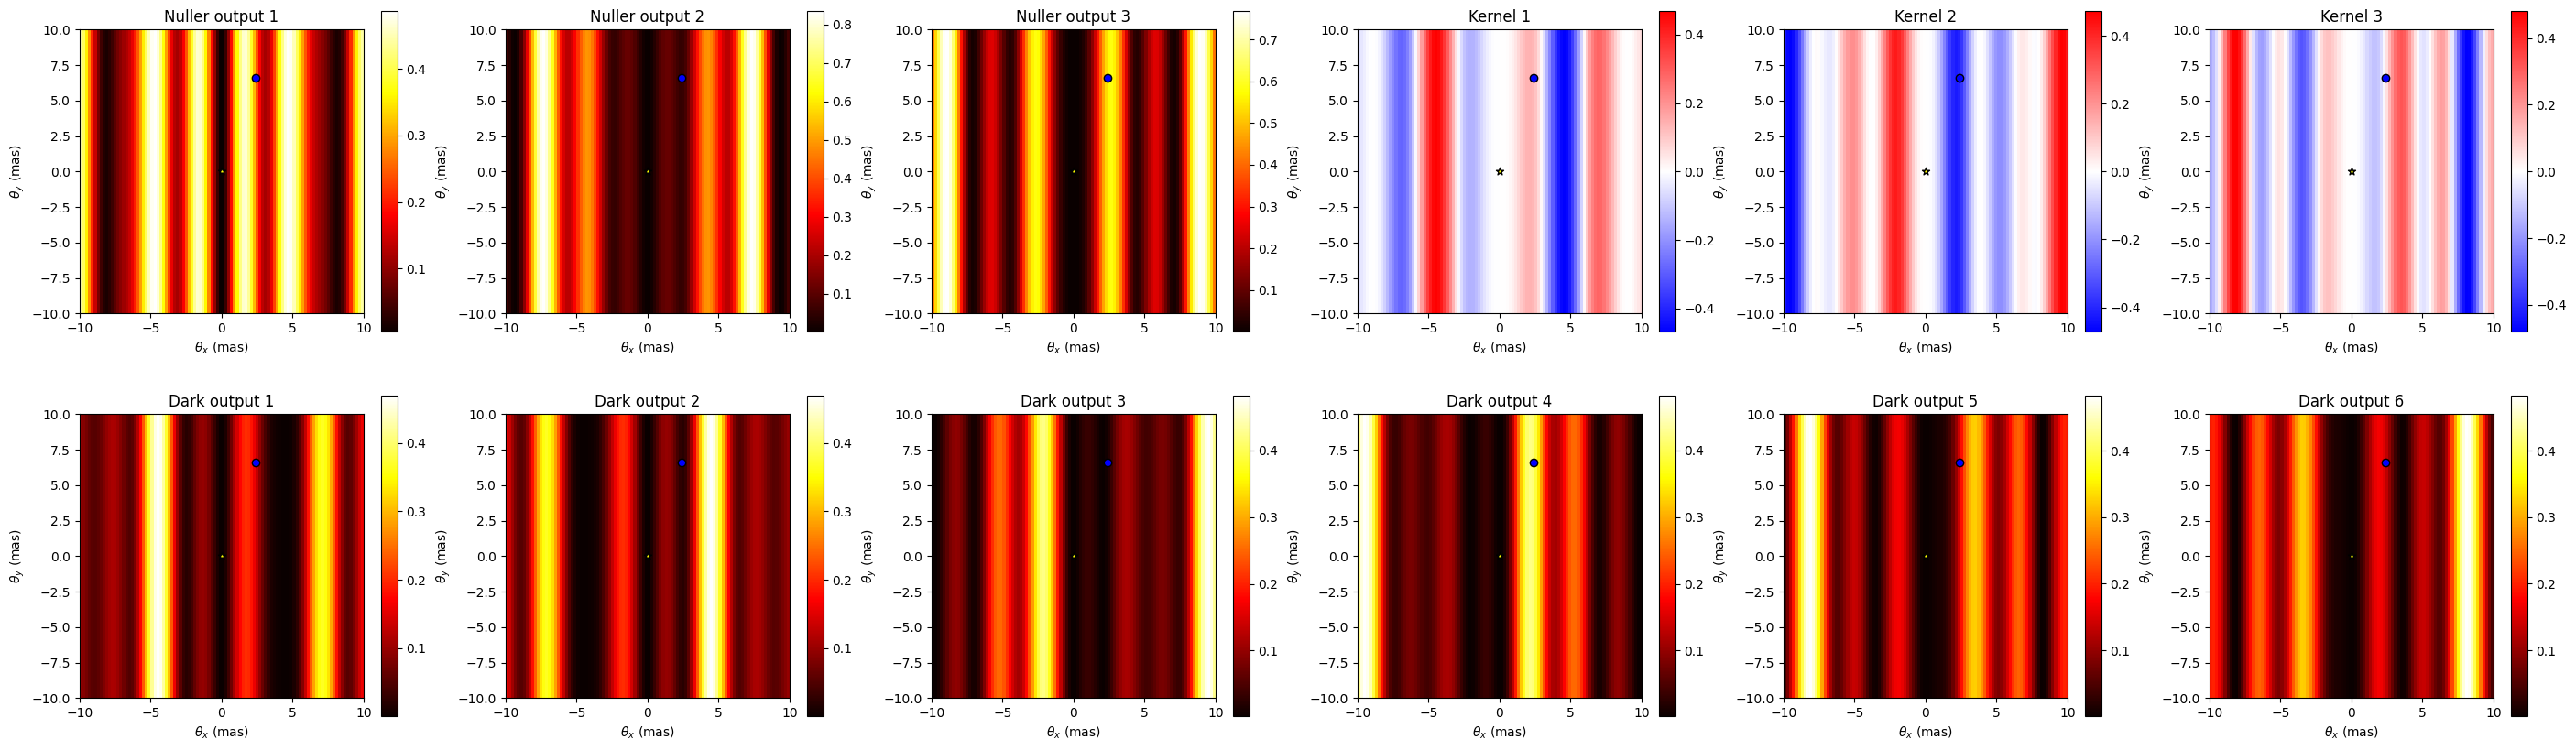

Planet input intensity: 1.00e-06
Planet intensity on null outputs: 2.88e-07 | 5.57e-08 | 5.50e-07
Planet intensity on dark outputs: 1.49e-07 | 2.28e-08 | 1.05e-08 | 4.09e-07 | 1.57e-07 | 1.46e-07
Planet intensity on kernel outputs: 1.26e-07 | -3.98e-07 | 1.03e-08
Planet intensity on bright output: 1.06e-07


In [61]:
def plot_transmission_maps(
    shifts: u.Quantity = np.zeros(14) * L.unit,
    shifts_total_opd: u.Quantity = np.zeros(14) * L.unit,
    resolution: int = 100,
) -> None:

    hour_angle_slider = widgets.FloatSlider(
        value=0,
        min=-DH.value/2,
        max=DH.value/2,
        step=0.01,
        description='Hour angle:',
    )

    latitude_slider = widgets.FloatSlider(
        value=LATITUDE.to(u.deg).value,
        min=-90,
        max=90,
        step=0.01,
        description='Latitude:',
    )

    declination_slider = widgets.FloatSlider(
        value=DECLINATION.to(u.deg).value,
        min=-90,
        max=90,
        step=0.01,
        description='Declination:',
    )

    # plot = widgets.Image(format='png', width=1000, height=500)

    # input_label = widgets.Label()
    # null_label = widgets.Label()
    # dark_label = widgets.Label()
    # kernel_label = widgets.Label()
    # bright_label = widgets.Label()

    reset = widgets.Button(description="Reset values")

    run = widgets.Button(description="Run")

    def update_plot(*args):
        run.button_style = "warning"

        clear_output()
        display(widgets.VBox([hour_angle_slider, latitude_slider, declination_slider, widgets.HBox([reset, run])]))

        null_maps, dark_maps, kernel_maps = get_transmission_map(
            resolution,
            shifts,
            shifts_total_opd,
            projected_telescope_positions = project_baseline(
                TELESCOPE_POSITIONS,
                h=hour_angle_slider.value*u.deg,
                l=latitude_slider.value*u.deg,
                d=declination_slider.value*u.deg
            )
        )
    
        planet_x, planet_y = alpha_theta_to_fov_map_coord(ALPHA, THETA)

        _, axs = plt.subplots(2, 6, figsize=(35, 10))
        for i in range(3):
            im = axs[0, i].imshow(
                null_maps[i], aspect="equal", cmap="hot", extent=EXTENT
            )
            axs[0, i].set_title(f"Nuller output {i+1}")
            axs[0, i].set_xlabel(r"$\theta_x$" + f" ({FOV.unit})")
            axs[0, i].set_ylabel(r"$\theta_y$" + f" ({FOV.unit})")
            plt.colorbar(im, ax=axs[0, i])

            axs[0, i].scatter(0, 0, color="yellow", marker="*", edgecolors="black")
            axs[0, i].scatter(planet_x, planet_y, color="blue", edgecolors="black")

        for i in range(6):
            im = axs[1, i].imshow(
                dark_maps[i], aspect="equal", cmap="hot", extent=EXTENT
            )
            axs[1, i].set_title(f"Dark output {i+1}")
            axs[1, i].set_xlabel(r"$\theta_x$" + f" ({FOV.unit})")
            axs[1, i].set_ylabel(r"$\theta_y$" + f" ({FOV.unit})")
            axs[1, i].set_aspect("equal")
            plt.colorbar(im, ax=axs[1, i])

            axs[1, i].scatter(0, 0, color="yellow", marker="*", edgecolors="black")
            axs[1, i].scatter(planet_x, planet_y, color="blue", edgecolors="black")

        for i in range(3):
            im = axs[0, i + 3].imshow(
                kernel_maps[i], aspect="equal", cmap="bwr", extent=EXTENT
            )
            axs[0, i + 3].set_title(f"Kernel {i+1}")
            axs[0, i + 3].set_xlabel(r"$\theta_x$" + f" ({FOV.unit})")
            axs[0, i + 3].set_ylabel(r"$\theta_y$" + f" ({FOV.unit})")
            plt.colorbar(im, ax=axs[0, i + 3])

            axs[0, i + 3].scatter(0, 0, color="yellow", marker="*", edgecolors="black")
            axs[0, i + 3].scatter(planet_x, planet_y, color="blue", edgecolors="black")

        plt.show()

        # buffer = BytesIO()
        # plt.savefig(buffer,format='png')
        # plt.close()
        # plot.value = buffer.getvalue()

        signals = acquire_signals(PLANET_LIGHT)
        nulls, darks, kernels, bright = kn(signals, shifts_total_opd=np.zeros(14) * L.unit)

        # input_label.value = f"Planet input intensity: {np.abs(PLANET_LIGHT)**2:.2e}"
        # null_label.value = f"Planet intensity on null outputs: {' | '.join([f'{np.abs(n)**2:.2e}' for n in nulls])}"
        # dark_label.value = f"Planet intensity on dark outputs: {' | '.join([f'{np.abs(d)**2:.2e}' for d in darks])}"
        # kernel_label.value = f"Planet intensity on kernel outputs: {' | '.join([f'{k:.2e}' for k in kernels])}"
        # bright_label.value = f"Planet intensity on bright output: {np.abs(bright)**2:.2e}"

        print(f"Planet input intensity: {np.abs(PLANET_LIGHT)**2:.2e}")
        print(f"Planet intensity on null outputs: {' | '.join([f'{np.abs(n)**2:.2e}' for n in nulls])}")
        print(f"Planet intensity on dark outputs: {' | '.join([f'{np.abs(d)**2:.2e}' for d in darks])}")
        print(f"Planet intensity on kernel outputs: {' | '.join([f'{k:.2e}' for k in kernels])}")
        print(f"Planet intensity on bright output: {np.abs(bright)**2:.2e}")
        
        run.button_style = ""

    def reset_values(*args):
        hour_angle_slider.value = 0
        latitude_slider.value = LATITUDE.to(u.deg).value
        declination_slider.value = DECLINATION.to(u.deg).value
        run.color = "blue"
        enable_run()

    def enable_run(*args):
        run.button_style = "success"
    
    reset.on_click(reset_values)
    hour_angle_slider.observe(enable_run)
    latitude_slider.observe(enable_run)
    declination_slider.observe(enable_run)
    run.on_click(update_plot)
    update_plot()

plot_transmission_maps(resolution=100)

---

<div align=center>

# 🪛 **Calibration**

</div>

## 🫳 Manual shift controls

In [24]:
def manual_shift_control():
    step = 1e-20

    # Build sliders -----------------------------------------------------------

    # Input amplitude
    IA_sliders = [
        widgets.FloatSlider(
            value=1/np.sqrt(4), min=0, max=1, step=step, description=f"I{i+1}"
        )
        for i in range(4)
    ]

    # Input phase
    IP_sliders = [
        widgets.FloatSlider(
            value=0, min=0, max=L.value, step=step, description=f"I{i+1}"
        )
        for i in range(4)
    ]

    # Shifter phase
    P_sliders = [
        widgets.FloatSlider(
            value=0, min=0, max=L.value, step=step, description=f"P{i+1}"
        )
        for i in range(14)
    ]

    # Build GUI ---------------------------------------------------------------

    def beam_repr(beam: complex) -> str:
        return f"<b>{np.abs(beam):.2e}</b> * exp(<b>{np.angle(beam)/np.pi:.2f}</b> pi i)"

    inputs = [widgets.HTML(value=f" ") for _ in range(4)]
    null_outputs = [widgets.HTML(value=f" ") for _ in range(4)]
    dark_outputs = [widgets.HTML(value=f" ") for _ in range(6)]
    kernel_outputs = [widgets.HTML(value=f" ") for _ in range(3)]

    def update_gui(*args):

        signal = np.array([
            IA_sliders[i].value * np.exp(1j * IP_sliders[i].value / L.value * 2 * np.pi)
            for i in range(4)
        ])

        nulls, darks, kernels, bright = kn(
            beams=signal, shifts=np.array([x.value for x in P_sliders]) * L.unit, shifts_total_opd=np.zeros(14) * L.unit
        )

        for i, beam in enumerate(signal):
            inputs[i].value = (
                f"<b>Input {i+1} -</b> Amplitude: <code>{beam_repr(beam)}</code> Intensity: <code><b>{np.abs(beam)**2:.2e}</b></code>"
            )
        null_outputs[0].value = (
            f"<b>N3a -</b> Amplitude: <code>{beam_repr(bright)}</code> Intensity: <code><b>{np.abs(bright)**2:.2e}</b></code> <b><- Bright channel</b>"
        )
        for i, beam in enumerate(nulls):
            null_outputs[i + 1].value = (
                f"<b>N{i//2+3}{['a','b'][(i+1)%2]} -</b> Amplitude: <code>{beam_repr(beam)}</code> Intensity: <code><b>{np.abs(beam)**2:.2e}</b></code>"
            )
        for i, beam in enumerate(darks):
            dark_outputs[i].value = (
                f"<b>Dark {i+1} -</b> Amplitude: <code>{beam_repr(beam)}</code> Intensity: <code><b>{np.abs(beam)**2:.2e}</b></code>"
            )
        for i, beam in enumerate(kernels):
            kernel_outputs[i].value = (
                f"<b>Kernel {i+1} -</b> Value: <code>{beam:.2e}</code>"
            )   
            
        # fig, ax = plt.subplots(1, 1, figsize=(5, 5))

        # Plot intensities
        for i in range(len(signal)):
            plt.imshow([[np.abs(signal[i])**2,],], cmap="hot", vmin=0, vmax=np.sum(np.abs(signal)**2))
            plt.savefig(fname=f"img/tmp.png", format="png")
            plt.close()
            with open("img/tmp.png", "rb") as file:
                image = file.read()
                photometric_cameras[i].value = image
        for i in range(len(nulls)+1):
            if i == 0:
                plt.imshow([[np.abs(bright)**2,],], cmap="hot", vmin=0, vmax=np.sum(np.abs(nulls)**2) + np.abs(bright)**2)
            else:
                plt.imshow([[np.abs(nulls[i-1])**2,],], cmap="hot", vmin=0, vmax=np.sum(np.abs(nulls)**2) + np.abs(bright)**2)
            plt.savefig(fname=f"img/tmp.png", format="png")
            plt.close()
            with open("img/tmp.png", "rb") as file:
                image = file.read()
                null_cameras[i].value = image
        for i in range(len(darks)):
            plt.imshow([[np.abs(darks[i])**2,],], cmap="hot", vmin=0, vmax=np.sum(np.abs(darks)**2))
            plt.savefig(fname=f"img/tmp.png", format="png")
            plt.close()
            with open("img/tmp.png", "rb") as file:
                image = file.read()
                dark_cameras[i].value = image
        for i in range(len(kernels)):
            plt.imshow([[kernels[i],],], cmap="bwr", vmin=-np.max(np.abs(kernels)), vmax=np.max(np.abs(kernels)))
            plt.savefig(fname=f"img/tmp.png", format="png")
            plt.close()
            with open("img/tmp.png", "rb") as file:
                image = file.read()
                kernel_cameras[i].value = image

        os.remove("img/tmp.png")
        


        return bright, darks
    
    photometric_cameras = [widgets.Image(width=50,height=50) for _ in range(4)]
    null_cameras = [widgets.Image(width=50,height=50) for _ in range(4)]
    dark_cameras = [widgets.Image(width=50,height=50) for _ in range(6)]
    kernel_cameras = [widgets.Image(width=50,height=50) for _ in range(3)]

    

    vbox = widgets.VBox(
        [
            widgets.HTML("<h1>Inputs</h1>"),
            widgets.HTML("Amplitude:"),
            widgets.HBox(IA_sliders[:4]),
            widgets.HTML("Phase:"),
            widgets.HBox(IP_sliders[:4]),
            *[widgets.HBox([photometric_cameras[i], x]) for i, x in enumerate(inputs)],
            widgets.HTML("<h1>Nuller</h1>"),
            widgets.HBox(P_sliders[:4]),
            widgets.HBox(P_sliders[4:8]),
            *[widgets.HBox([null_cameras[i], x]) for i, x in enumerate(null_outputs)],
            widgets.HTML("<h1>Recombiner</h1>"),
            widgets.HBox(P_sliders[8:11]),
            widgets.HBox(P_sliders[11:14]),
            *[widgets.HBox([dark_cameras[i], x]) for i, x in enumerate(dark_outputs)],
            widgets.HTML("<h1>Kernels</h1>"),
            *[widgets.HBox([kernel_cameras[i], x]) for i, x in enumerate(kernel_outputs)],
        ]
    )

    # Link sliders to update function ------------------------------------------

    for widget in P_sliders:
        widget.observe(update_gui, "value")
    for widget in IA_sliders:
        widget.observe(update_gui, "value")
    for widget in IP_sliders:
        widget.observe(update_gui, "value")

    update_gui()
    return vbox

manual_shift_control()

## 🧬 Genetic algorithm

### Algorithm

in order to get the best shifts to inject to optimize the component performances, I made a genetic algorithme that iteratively mutate a shifter and keep the mutation if it minimize a metric that is defined such as:

$$
M = \frac{|K_1| + |K_2| + |K_3|}{|B|^2}
$$

In [25]:
def calibrate(verbose: bool = False) -> tuple[u.Quantity, dict[str, np.ndarray[float]]]:
    """
    Optimize the phase shifters offsets to maximize the nulling performance

    Parameters
    ----------
    - kn: Kernel-Nuller object
    - beams: List of input beams complex amplitudes
    - verbose: Boolean, if True, print the optimization process

    Returns
    -------
    - Array of optimized phase shifters offsets
    - Dict containing the history of the optimization
    """

    shifts = np.zeros(14) * L.unit

    treshold = 1e-20 * L.unit # Minimum shift step size
    decay = 1.1  # Decay factor for the step size (delta /= decay)

    # Shifters that contribute to redirecting light to the bright output
    # p1 = [2,3,4,5,7]
    p1 = [1, 2, 3, 4, 5, 7]

    # Shifters that contribute to the symmetry of the dark outputs
    # p2 = [6,8,11,13,14]
    p2 = [6, 8, 9, 10, 11, 12, 13, 14]

    # History of the optimization
    bright_history = []
    asymmetry_history = []
    shifters_history = []

    delta = L / 4
    while delta > treshold:

        if verbose:
            print(color.black(color.on_red(f"--- New iteration ---")), f"Delta={delta:.2e}")

        for p in p1 + p2:
            log = ""

            # Step vector
            step = np.zeros(14) * L.unit
            step[p - 1] = delta

            # Apply the step
            _, _, kernels_old, bright_old = kn(beams=STAR_SIGNALS, shifts=shifts)
            _, _, kernels_pos, bright_pos = kn(beams=STAR_SIGNALS, shifts=shifts + step)
            _, _, kernels_neg, bright_neg = kn(beams=STAR_SIGNALS, shifts=shifts - step)

            # Compute the metrics
            bright_neg = np.abs(bright_neg) ** 2
            bright_old = np.abs(bright_old) ** 2
            bright_pos = np.abs(bright_pos) ** 2
            metric_neg = np.sum(np.abs(kernels_neg))
            metric_old = np.sum(np.abs(kernels_old))
            metric_pos = np.sum(np.abs(kernels_pos))
            
            # metric_neg = np.sum(np.abs(kernels_neg)) / bright_neg
            # metric_old = np.sum(np.abs(kernels_old)) / bright_old
            # metric_pos = np.sum(np.abs(kernels_pos)) / bright_pos

            log += "Shift " + color.black(color.on_lightgrey(f"{p}")) + " Bright: " + color.black(color.on_green(f"{bright_neg:.2e} | {bright_old:.2e} | {bright_pos:.2e}")) + " Asymmetry:  " + color.black(color.on_blue(f"{metric_neg:.2e} | {metric_old:.2e} | {metric_pos:.2e}")) + " -> "

            # Save the history
            bright_history.append(bright_old)
            asymmetry_history.append(metric_old)
            shifters_history.append(np.copy(shifts))

            # Maximize the bright metric for group 1 shifters
            if p in p1:
                if bright_pos > bright_old and bright_pos > bright_neg:
                    log += color.black(color.on_green(" + "))
                    shifts += step
                elif bright_neg > bright_old and bright_neg > bright_pos:
                    log += color.black(color.on_green(" - "))
                    shifts -= step
                else:
                    log += color.black(color.on_green(" = "))

            # Minimize the asymmetry metric for group 2 shifters
            else:
                if metric_pos < metric_old and metric_pos < metric_neg:
                    shifts += step
                    log += color.black(color.on_blue(" + "))
                elif metric_neg < metric_old and metric_neg < metric_pos:
                    shifts -= step
                    log += color.black(color.on_blue(" - "))
                else:
                    log += color.black(color.on_blue(" = "))

            # if metric_pos < metric_old and metric_pos < metric_neg:
            #     shifts += step
            #     log += color.black(color.on_blue(" + "))
            # elif metric_neg < metric_old and metric_neg < metric_pos:
            #     shifts -= step
            #     log += color.black(color.on_blue(" - "))
            # else:
            #     log += color.black(color.on_blue(" = "))
            
            if verbose:
                print(log)

        delta /= decay

    return bound_phase(shifts), {
        "bright": np.array(bright_history),
        "asymmetry": np.array(asymmetry_history),
        "shifters": np.array(shifters_history),
    }

OPTIMIZED_SHIFTS, CALIBRATION_HISTORY = calibrate()

1.2217304763960306 rad 7.0 mas
2.3941410032796817 mas 6.5778483455013586 mas


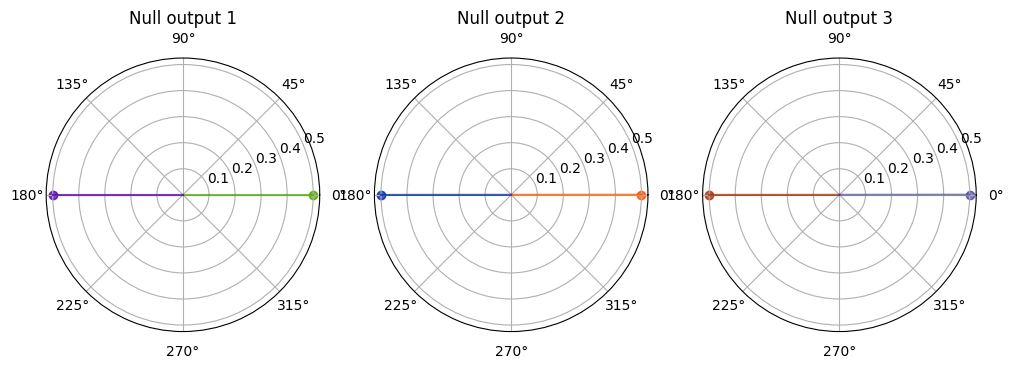

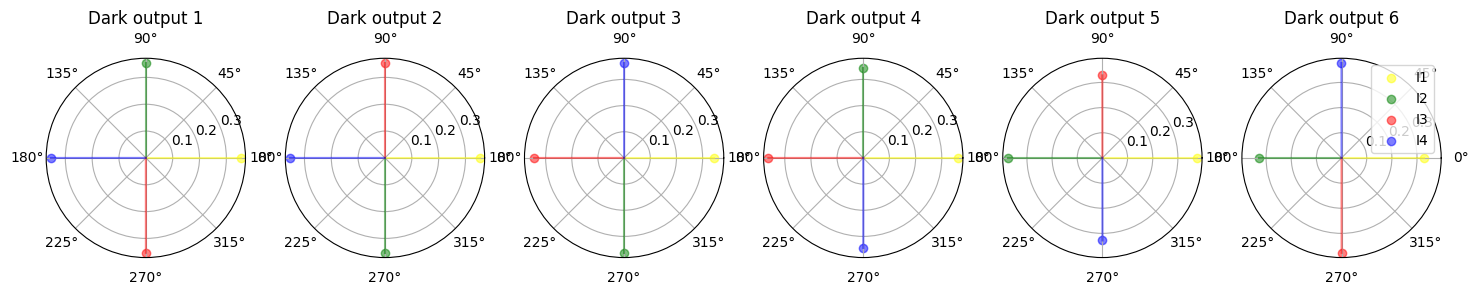

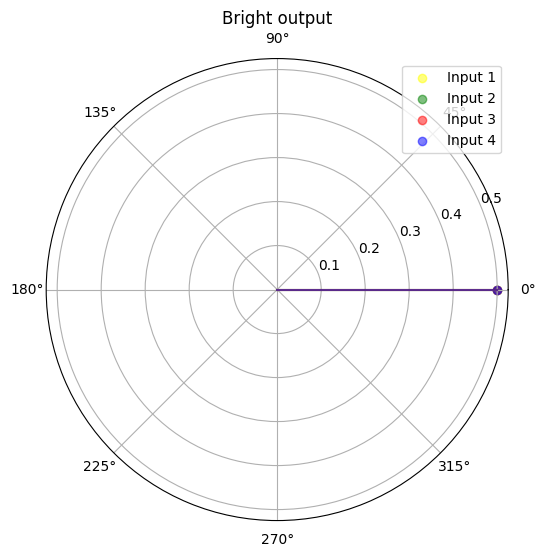

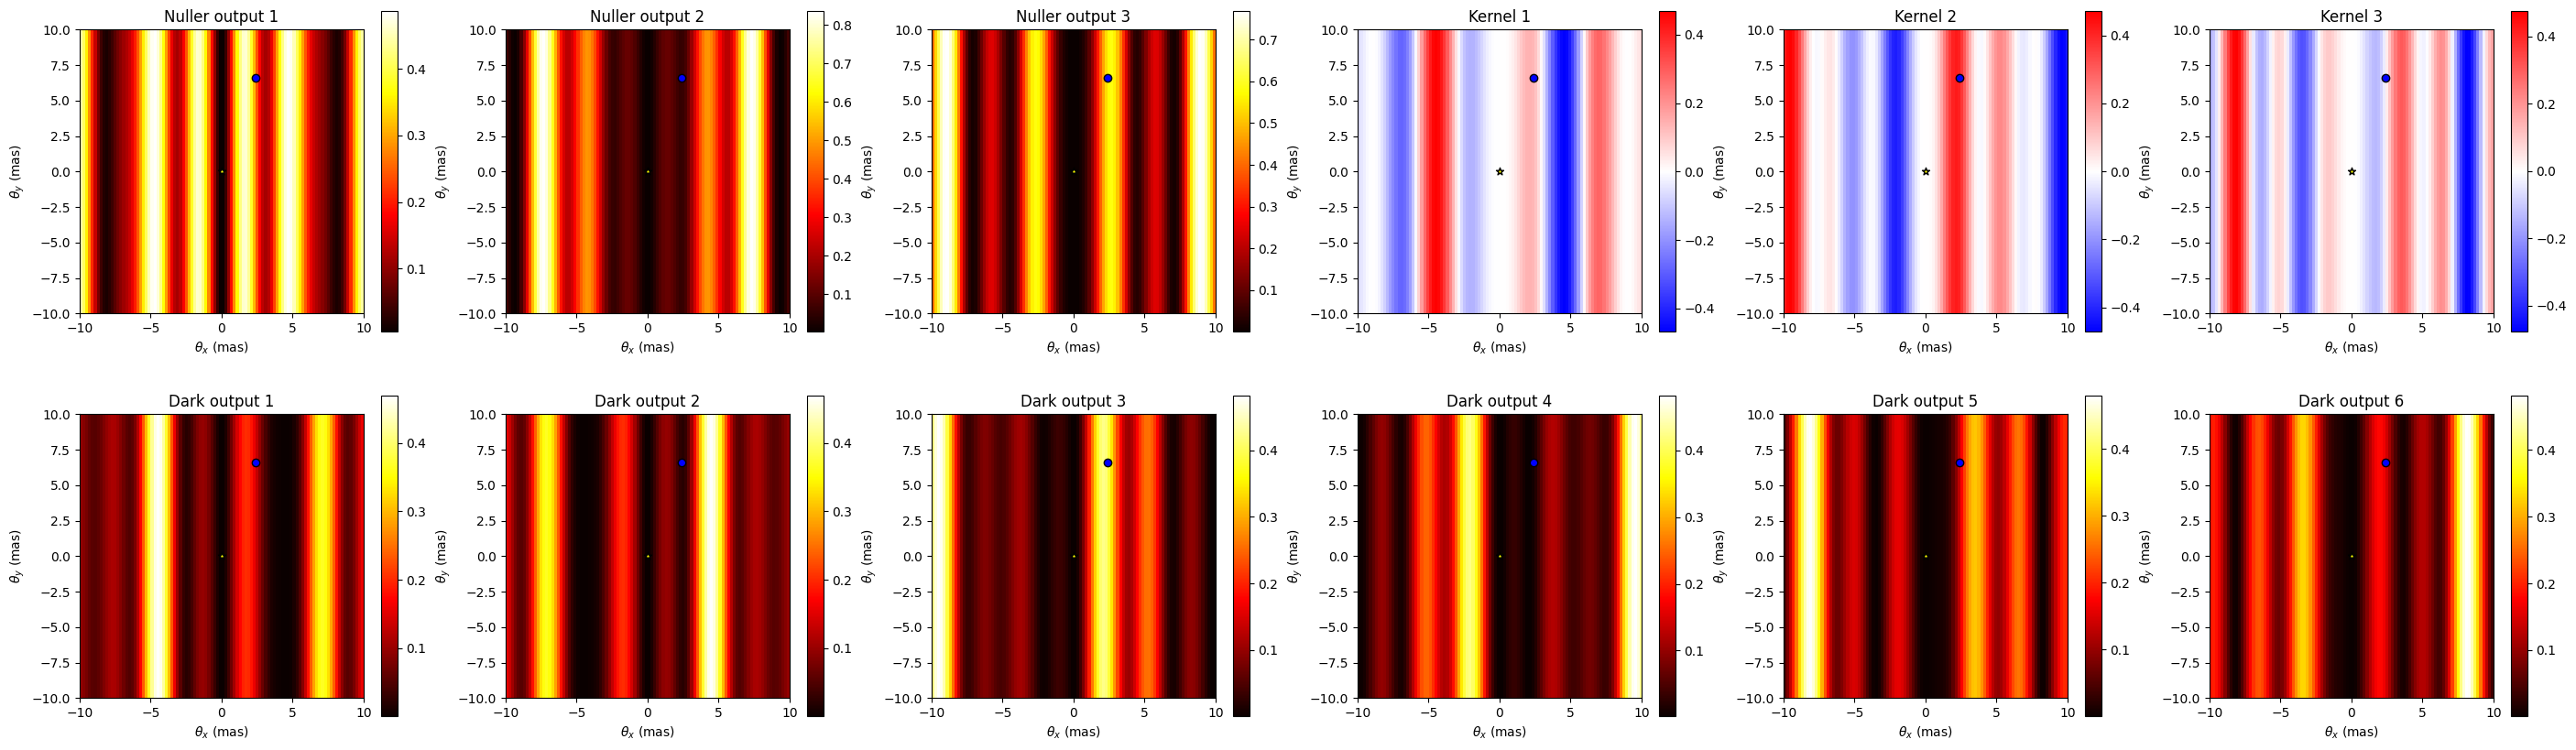

Planet input intensity: 1.00e-06
Planet intensity on null outputs: 2.88e-07 | 5.57e-08 | 5.50e-07
Planet intensity on dark outputs: 1.49e-07 | 2.28e-08 | 1.05e-08 | 4.09e-07 | 1.57e-07 | 1.46e-07
Planet intensity on kernel outputs: 1.26e-07 | -3.98e-07 | 1.03e-08
Planet intensity on bright output: 1.06e-07


In [26]:
def plot_optimization_history():
    bright_evol, dark_asymmetry_evol, shifts_evol = CALIBRATION_HISTORY["bright"], CALIBRATION_HISTORY["asymmetry"], CALIBRATION_HISTORY["shifters"]

    plt.figure(figsize=(15, 5))
    plt.plot(bright_evol)
    plt.xlabel("Number of iterations")
    plt.ylabel("Bright output intensity")
    plt.yscale("log")
    plt.title("Optimization of the bright output")
    plt.show()

    plt.figure(figsize=(15, 5))
    plt.plot(dark_asymmetry_evol)
    plt.xlabel("Number of iterations")
    plt.ylabel("Dark pairs intensity difference")
    plt.yscale("log")
    plt.title("Optimization of the kernels")
    plt.show()

    plt.figure(figsize=(15, 5))
    for i in range(shifts_evol.shape[1]):
        plt.plot(shifts_evol[:,i], label=f"Shifter {i+1}")
    plt.xlabel("Number of iterations")
    plt.ylabel("Phase shift")
    plt.yscale("linear")
    plt.title("Convergeance of the phase shifters")
    plt.legend(loc='upper right')
    plt.show()

plot_optimization_history()
plot_kn_phase_effect(shifts=OPTIMIZED_SHIFTS)
plot_transmission_maps(shifts=OPTIMIZED_SHIFTS, shifts_total_opd=SHIFTS_TOTAL_OPD)

### Reliability (WIP)

In [27]:
def optimization_emprical_proof():

    _, axs = plt.subplots(2, 7, figsize=(20, 5))
    axs = axs.flatten()

    _, axs2 = plt.subplots(2, 7, figsize=(20, 5))
    axs2 = axs2.flatten()

    for _ in range(100):
        shifts_total_opd = np.array(np.random.uniform(0, L.value, 14)) * L.unit
        optimized_shifts, _ = calibrate(shifts_total_opd=shifts_total_opd)

        E = bound_phase(shifts_total_opd)
        P = bound_phase(optimized_shifts)

        for i in range(14):
            axs[i].scatter(E[i], P[i], color='blue', s=1)
            axs[i].set_xlabel("Introduced error")
            axs[i].set_ylabel("Optimized shift")
            axs[i].set_title(f"P{i+1}")

        def bound(p):
            return bound_phase(p)

        axs2[0].scatter(bound(E[0] - E[1]), bound(P[0] - P[1]), color='blue', s=1)
        axs2[0].set_title("P1-P2")
        axs2[1].scatter(bound(E[2] - E[3]), bound(P[2] - P[3]), color='blue', s=1)
        axs2[1].set_title("P3-P4")
        axs2[2].scatter(bound(E[4] - E[6]), bound(P[4] - P[6]), color='blue', s=1)
        axs2[2].set_title("P5 - P7")
        axs2[3].scatter(bound(E[5] - E[7]), bound(P[5] - P[7]), color='blue', s=1)
        axs2[3].set_title("P6 - P8")
        axs2[4].scatter(bound(E[8] - E[10]), bound(P[8] - P[10]), color='blue', s=1)
        axs2[4].set_title("P9 - P11")
        axs2[5].scatter(bound(E[9] - E[12]), bound(P[9] - P[12]), color='blue', s=1)
        axs2[5].set_title("P10 - P13")
        axs2[6].scatter(bound(E[11] - E[13]), bound(P[11] - P[13]), color='blue', s=1)
        axs2[6].set_title("P12 - P14")

        axs2[7].scatter(bound((E[0] + E[1]) - (E[2] + E[3])), bound((P[0] + P[1]) - (P[2] + P[3])), color='blue', s=1)
        axs2[7].set_title("(P1-P2)*P5 - (P3-P4)*P7")

        axs2[8].scatter((E[0] + E[1])/2 * E[4] - ((E[2] + E[3])/2 * E[6]), ((P[0] + P[1])/2 * P[4]) - ((P[2] + P[3])/2 * P[6]), color='blue', s=1)
        axs2[8].set_title("(P1+P2)/2*P5 - (P3+P4)/2*P7")

        for i in range(14):
            axs2[i].set_xlabel("Introduced error")
            axs2[i].set_ylabel("Optimized shift")

    plt.show()

# optimization_emprical_proof()

## 🤖 Machine Learning Approach

Another approach to retrieve the correct shifts inject is to use machine learning techniques. There is several ways to do so. Here we will focus a supervised dense neural network. To do so, we will have to build a dataset.

As the solutions are degenerated, we will not ask the network to predict the best shift to inject, but we will ask it to predict the shfit aberrations instead. From these aberation, we are able to determine a solution for the shifts to inject.

As input of the network, we need to give enough information to caracterize the parameter space. The most straightforward approach would be to create a grid in the parameter space and give the kenrel outputs for each of the point in these grid.

Unfortunately, we work in a parameter space of 14 dimensions which is too large to be covered by a grid. A solution is to consider only the vectors that form the cardinal basis of this parameter space.

### Dataset generation

In [28]:
def parameter_grid(N, D, a, b):
    """
    Generate a list of points forming a grid in a parameter space.

    Parameters
    ----------
    - N: Resolution of the grid (point per axes)
    - D: Dimension of the space parameter
    - a: Minimum value of the space parameter
    - b: Maximum value of the space parameter

    Returns
    -------
    - An array of vectors describing a point in the parameter space
    """
    return np.array([a + (b-a) * (((x // N**np.arange(D,dtype=float)) % N)/N) for x in range(N**D)])

In [29]:
def parameter_basis(D, b=1):
    """
    Return the basis vectors of the parameter space (+ the null vector)

    Parameters
    ----------
    - D: Dimension of the space parameter
    - b: Norm of the basis vector (default=1)

    Returns
    -------
    - An array of vectors describing a point in the parameter space
    """

    vectors = np.zeros((D+1,D))
    for i in range(D):
        vectors[i+1,i] = b
    return vectors

In [30]:
def parameter_basis_2p(D, b=1):
    """
    Return the basis vectors of the parameter space (+ the null vector)

    Parameters
    ----------
    - D: Dimension of the space parameter
    - b: Norm of the basis vector (default=1)

    Returns
    -------
    - An array of vectors describing a point in the parameter space
    """

    vectors = np.zeros((2*D+1,D))
    for i in range(D):
        vectors[2*i+1,i] = b
        vectors[2*i+2,i] = 2*b
    return vectors

In [31]:
def get_dataset(size=1000):
    # grid_points = parameter_grid(2, 14, 0, 1.65)
    # grid_points = parameter_basis(14, 1.65/2)
    grid_points = parameter_basis_2p(14, 1.65/3)
    vector_len = len(grid_points)*7 + 14
    dataset = np.empty((size, vector_len))

    for v in range(size):

        shifts_total_opd = np.random.uniform(0, 1, 14) * L
        vector = np.empty(vector_len)

        for p, point in enumerate(grid_points):
            _, darks, _, bright = kn_njit(beams=STAR_SIGNALS, shifts=point, shifts_total_opd=shifts_total_opd) 

            vector[p*7:p*7+6] = np.abs(darks)**2
            vector[p*7+6] = np.abs(bright)**2

        vector[-14:] = shifts_total_opd
        dataset[v] = vector

    return dataset

DATASET = get_dataset(10_000)
print(DATASET.shape)

(10000, 217)


### Model definition (WIP)

In [32]:
def get_model(input_shape):
    i = tf.keras.Input(shape=(input_shape,), name='Input')
    x = tf.keras.layers.Dense(128, activation='relu', name='Dense_1')(i)
    x = tf.keras.layers.Dense(64, activation='relu', name='Dense_2')(x)
    x = tf.keras.layers.Dense(32, activation='relu', name='Dense_3')(x)
    o = tf.keras.layers.Dense(14, activation='relu', name='Output')(x)
    return tf.keras.Model(inputs=i, outputs=o)

MODEL = get_model(input_shape=DATASET.shape[1]-14)
MODEL.compile(optimizer='adam', loss='mse')
MODEL.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 203)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 128)            │        26,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 14)             │           462 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,910 (144.18 KB)

 Trainable params: 36,910 (144.18 KB)

 Non-trainable params: 0 (0.00 B)

### Model training

(10000, 217) (10000, 203) (10000, 14)
Epoch 1/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4947 - val_loss: 0.4200
Epoch 2/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - loss: 0.4210 - val_loss: 0.4199
Epoch 3/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - loss: 0.4193 - val_loss: 0.4200
Epoch 4/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 0.4186 - val_loss: 0.4201
Epoch 5/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 0.4172 - val_loss: 0.4197
Epoch 6/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 0.4188 - val_loss: 0.4202
Epoch 7/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - loss: 0.4180 - val_loss: 0.4199
Epoch 8/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - loss: 0.4195 - val_loss: 0.4195
Epoch 9/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 0.4187 - val_loss: 0.4195
Epoch 10/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 0.4178 - val_loss: 0.4198
Epoch 11/100
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4182 - va

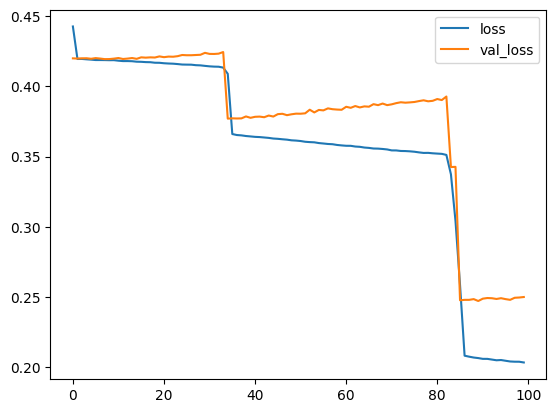

In [33]:
def train_model():
    X = DATASET[:, :-14]
    Y = DATASET[:, -14:]

    print(DATASET.shape, X.shape, Y.shape)

    return MODEL.fit(X, Y, epochs=100, batch_size=50, validation_split=0.2)

history = train_model()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


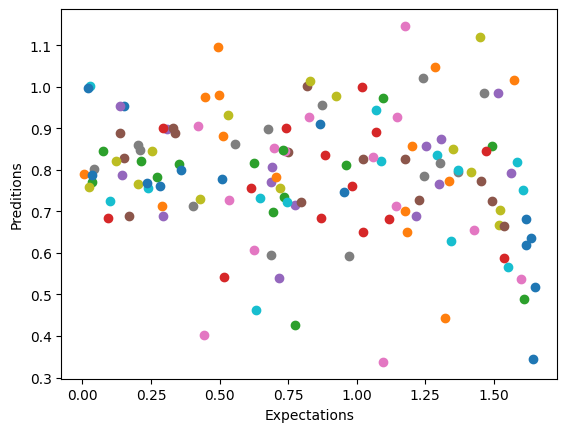

In [34]:
TEST_SET = get_dataset(size=10)
X = TEST_SET[:, :-14]
Y = TEST_SET[:, -14:]

PREDICTIONS = MODEL.predict(X)

# print(Y)
# print(PREDICTIONS)

cpt = 0
for i in range(10):
    for j in range(len(Y[i])):
        # print(f"Shifter {j}: E = {Y[i][j]:.2f}", f"P = {PREDICTIONS[i][j]:.2f}")
        plt.scatter(Y[i][j], PREDICTIONS[i][j])
        cpt += 1
    #     if cpt > 1:break
    # if cpt > 1:break

plt.xlabel("Expectations")
plt.ylabel("Preditions")
plt.show()

## 🎭 Shifters correlation

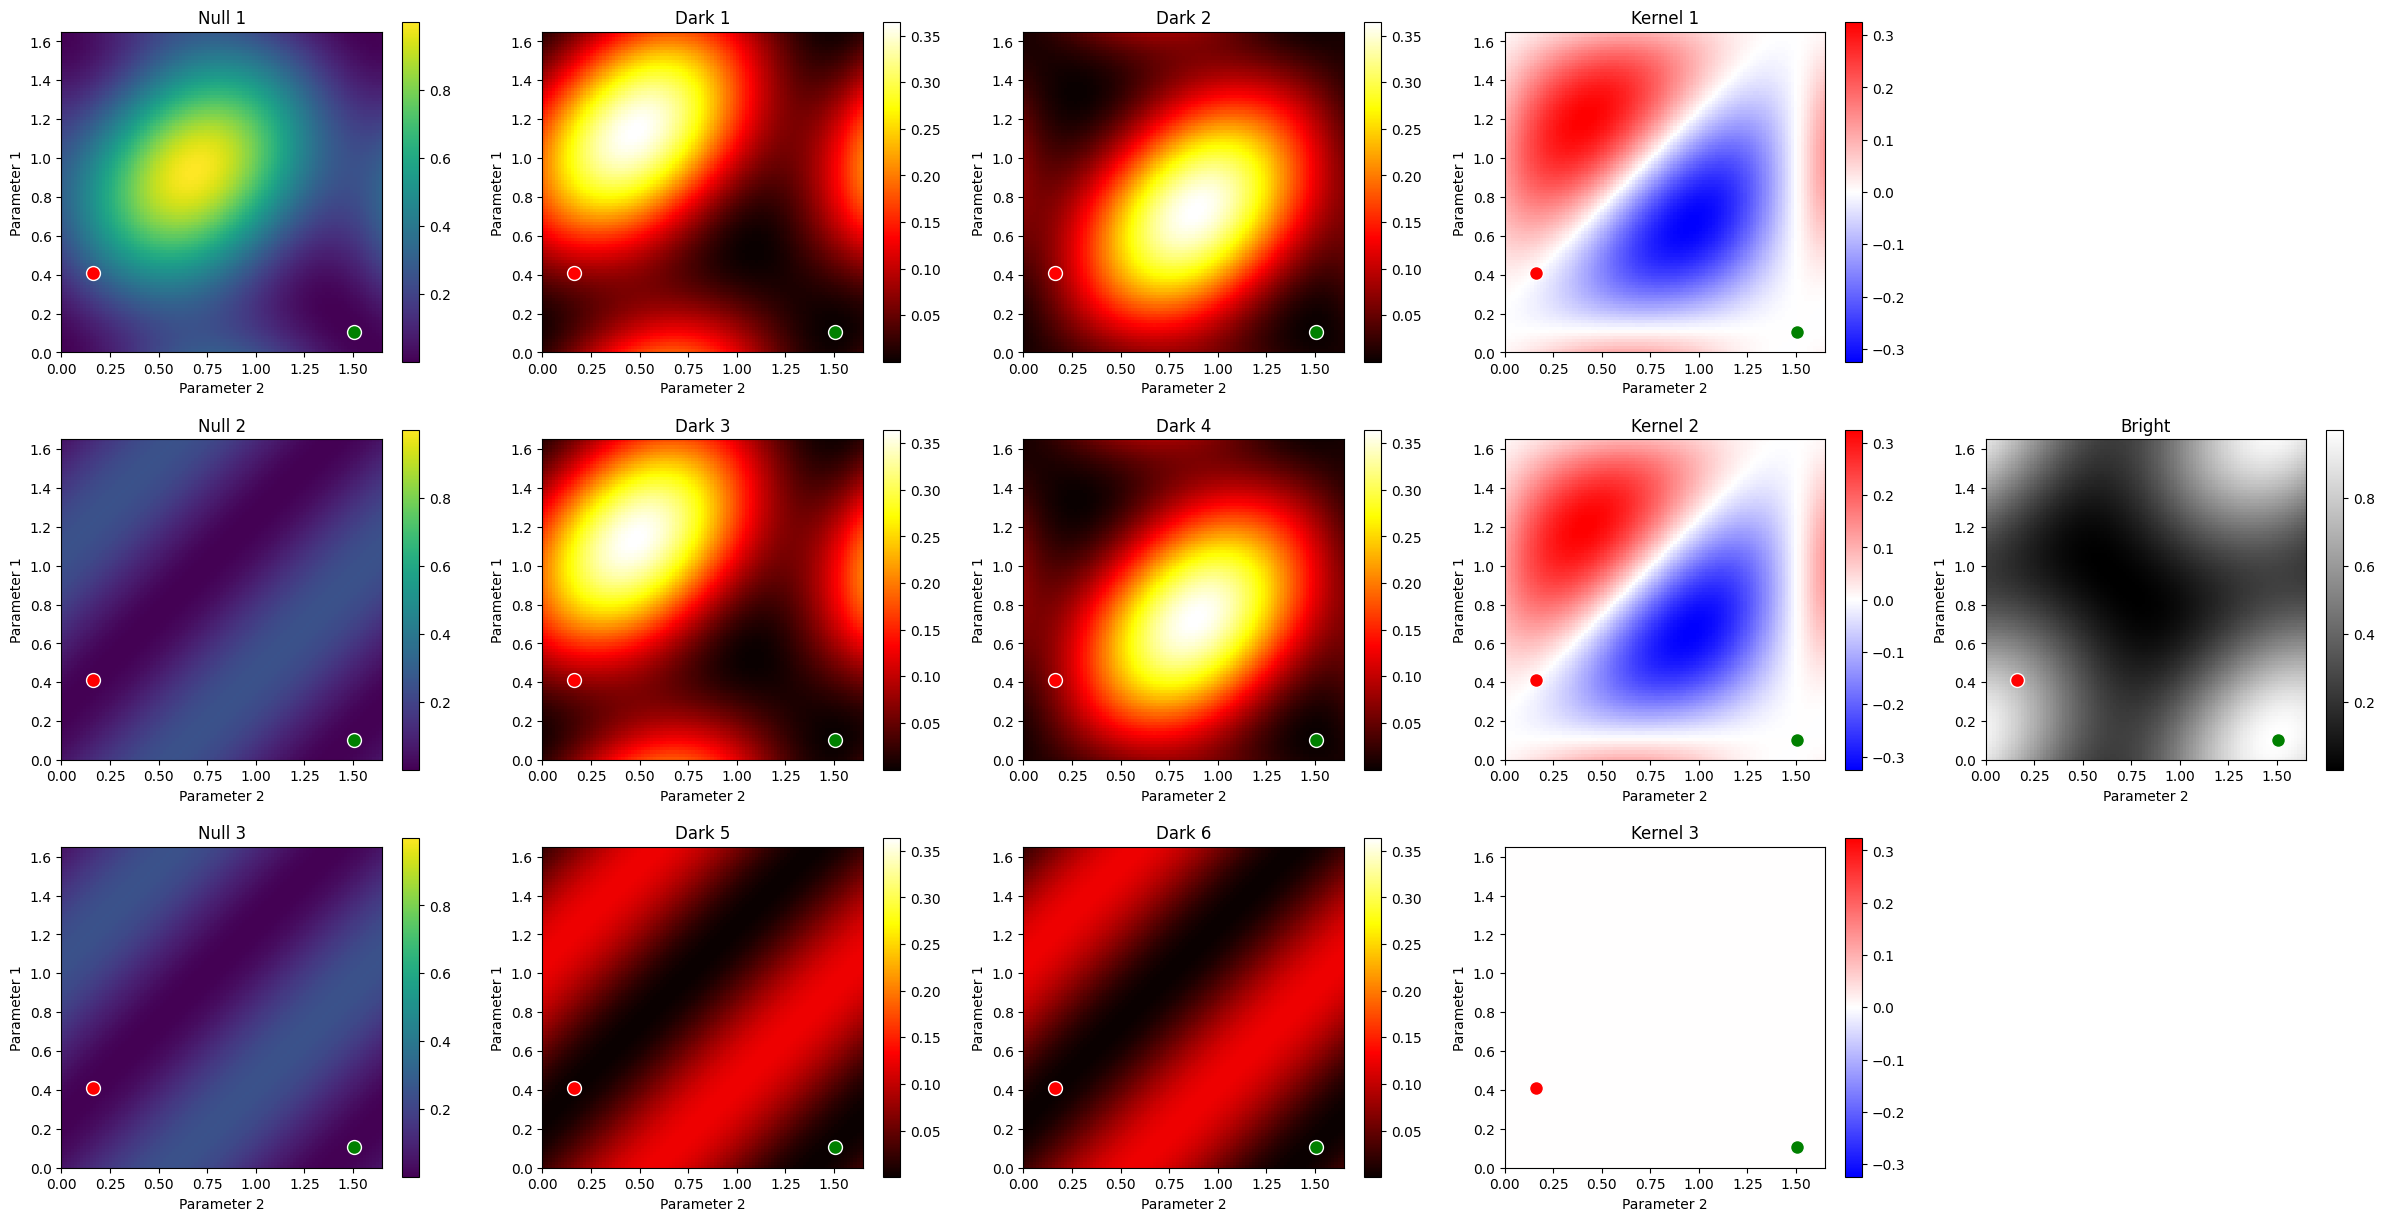

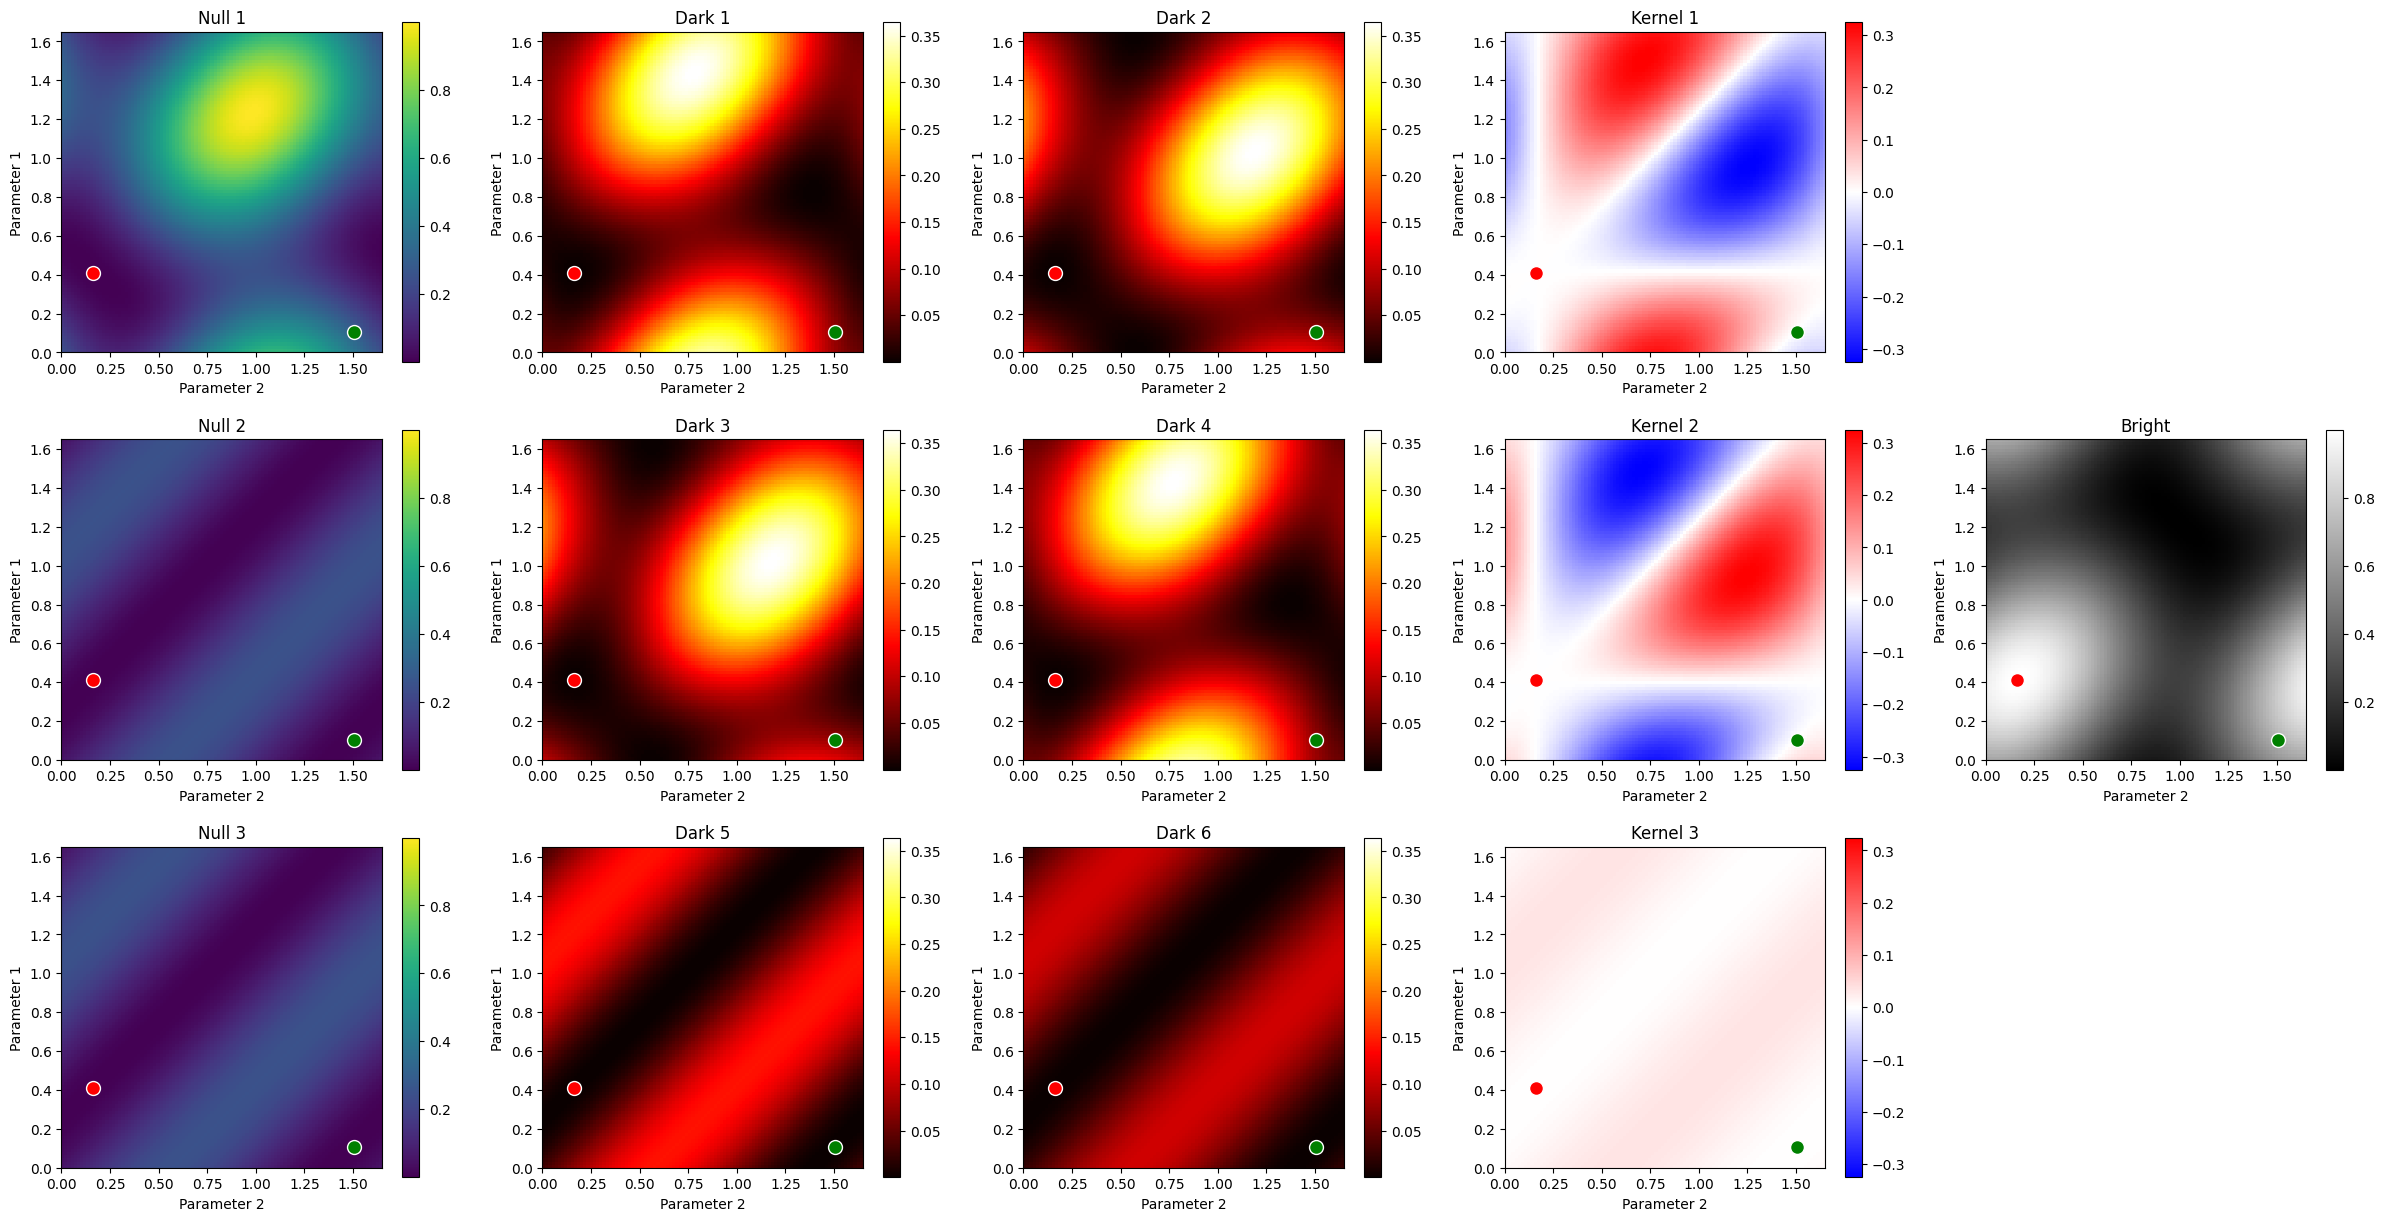

Optimized parameters
P1 = 0.41 um, ideal: 0.11 um
P2 = 0.16 um, ideal: 1.51 um
P3 = 0.00 um, ideal: 1.47 um
P4 = 0.20 um, ideal: 0.02 um
P5 = 0.00 um, ideal: 0.07 um
P6 = 0.00 um, ideal: 0.01 um
P7 = 0.00 um, ideal: 1.60 um
P8 = 1.57 um, ideal: 1.45 um
P9 = 0.07 um, ideal: 1.63 um
P10 = 1.25 um, ideal: 0.12 um
P11 = 0.02 um, ideal: 1.63 um
P12 = 1.44 um, ideal: 1.55 um
P13 = 0.19 um, ideal: 1.58 um
P14 = 1.59 um, ideal: 0.02 um


In [35]:
def scan(
    scan_on,
    restricted: bool = False,
):
    """
    Scan the parameter space and plot the null depths for each parameter
    combination.

    Parameters
    ----------
    - kn: An instance of the KernelNuller class.
    - beams: A list of 2D arrays, each representing a beam.
    - optimized_parameters: A list of 14 floats, the optimized parameters.

    Returns
    -------
    - None
    """

    # Scan shift power parameter space
    scan = np.linspace(0, L.value, 101, endpoint=True) * L.unit

    # Initialize the maps
    nulls_map = np.zeros((3, len(scan), len(scan)))
    darks_map = np.zeros((6, len(scan), len(scan)))
    kernels_map = np.zeros((3, len(scan), len(scan)))
    bright_map = np.zeros((len(scan), len(scan)))

    # Create the figure
    _, axs = plt.subplots(3, 5, figsize=(30, 15))

    # Consider only errors & correction on the shifter that are being scanned
    if restricted:
        shifts = np.zeros(14) * L.unit
        shifts_total_opd = np.zeros(14) * L.unit
        shifts_total_opd[scan_on[0] - 1] = SHIFTS_TOTAL_OPD[scan_on[0] - 1]
        shifts_total_opd[scan_on[1] - 1] = SHIFTS_TOTAL_OPD[scan_on[1] - 1]

    # Consider all shifter errors & corrections
    else:
        shifts = OPTIMIZED_SHIFTS.copy()
        shifts_total_opd = SHIFTS_TOTAL_OPD.copy()

    for i, scan1 in enumerate(scan):
        for j, scan2 in enumerate(scan):
            shifts[scan_on[0] - 1] = scan1
            shifts[scan_on[1] - 1] = scan2

            nulls, darks, kernels, bright = kn(beams=STAR_SIGNALS, shifts=shifts, shifts_total_opd=shifts_total_opd)

            for k, null in enumerate(nulls):
                nulls_map[k, i, j] = np.abs(null) ** 2
            for k, dark in enumerate(darks):
                darks_map[k, i, j] = np.abs(dark) ** 2
            for k, kernel in enumerate(kernels):
                kernels_map[k, i, j] = kernel
            bright_map[i, j] = np.abs(bright) ** 2

    for k in range(3):
        p = axs[k, 0]
        p.set_title(f"Null {k+1}")
        im = p.imshow(
            nulls_map[k],
            extent=[0, L.value, 0, L.value],
            vmin=np.min(nulls_map),
            vmax=np.max(nulls_map),
        )
        p.scatter(
            OPTIMIZED_SHIFTS[scan_on[1] - 1],
            OPTIMIZED_SHIFTS[scan_on[0] - 1],
            color="red",
            edgecolors="white",
            s=100,
        )
        p.scatter(
            IDEAL_SHIFTS[scan_on[1] - 1],
            IDEAL_SHIFTS[scan_on[0] - 1],
            color="green",
            edgecolors="white",
            s=100,
        )
        p.set_xlabel(f"Parameter {scan_on[1]}")
        p.set_ylabel(f"Parameter {scan_on[0]}")
        plt.colorbar(im)

    for k in range(6):
        p = axs[k // 2, k % 2 + 1]
        p.set_title(f"Dark {k+1}")
        im = p.imshow(
            darks_map[k],
            extent=[0, L.value, 0, L.value],
            vmin=np.min(darks_map),
            vmax=np.max(darks_map),
            cmap="hot",
        )
        p.scatter(
            OPTIMIZED_SHIFTS[scan_on[1] - 1],
            OPTIMIZED_SHIFTS[scan_on[0] - 1],
            color="red",
            edgecolors="white",
            s=100,
        )
        p.scatter(
            IDEAL_SHIFTS[scan_on[1] - 1],
            IDEAL_SHIFTS[scan_on[0] - 1],
            color="green",
            edgecolors="white",
            s=100,
        )
        p.set_xlabel(f"Parameter {scan_on[1]}")
        p.set_ylabel(f"Parameter {scan_on[0]}")
        plt.colorbar(im)

    for k in range(3):
        p = axs[k, 3]
        p.set_title(f"Kernel {k+1}")
        im = p.imshow(
            kernels_map[k],
            extent=[0, L.value, 0, L.value],
            vmin=np.min(kernels_map),
            vmax=np.max(kernels_map),
            cmap="bwr",
        )
        p.scatter(
            OPTIMIZED_SHIFTS[scan_on[1] - 1],
            OPTIMIZED_SHIFTS[scan_on[0] - 1],
            color="red",
            edgecolors="white",
            s=100,
        )
        p.scatter(
            IDEAL_SHIFTS[scan_on[1] - 1],
            IDEAL_SHIFTS[scan_on[0] - 1],
            color="green",
            edgecolors="white",
            s=100,
        )
        p.set_xlabel(f"Parameter {scan_on[1]}")
        p.set_ylabel(f"Parameter {scan_on[0]}")
        plt.colorbar(im)

    p = axs[1, 4]
    p.set_title(f"Bright")
    im = p.imshow(bright_map, extent=[0, L.value, 0, L.value], cmap="gray")
    p.scatter(
        OPTIMIZED_SHIFTS[scan_on[1] - 1],
        OPTIMIZED_SHIFTS[scan_on[0] - 1],
        color="red",
        edgecolors="white",
        s=100,
    )
    p.scatter(
        IDEAL_SHIFTS[scan_on[1] - 1],
        IDEAL_SHIFTS[scan_on[0] - 1],
        color="green",
        edgecolors="white",
        s=100,
    )
    p.set_xlabel(f"Parameter {scan_on[1]}")
    p.set_ylabel(f"Parameter {scan_on[0]}")
    plt.colorbar(im)

    axs[0, 4].axis("off")
    axs[2, 4].axis("off")

    plt.show()

scan_on = (1, 2)
scan(scan_on=scan_on, restricted=True)
scan(scan_on=scan_on, restricted=False)

print("Optimized parameters")
for i in range(14):
    print(f"P{i+1} = {OPTIMIZED_SHIFTS[i]:.2f}, ideal: {IDEAL_SHIFTS[i]:.2f}")

---

<div align=center>

# ⚙️ **Data generation**

</div>

## 🟨 Single observation

In [36]:
@nb.njit()
def bulk_observation_jitted(
    N: int = 1000,  # Number of observations
    star_signals: np.array = STAR_SIGNALS,  # Star signals
    planet_signals: np.array = PLANET_SIGNALS,  # Planet signals
    shifts: np.array = OPTIMIZED_SHIFTS.to(L.unit).value,  # Shifts to apply
    shifts_total_opd: np.array = SHIFTS_TOTAL_OPD.to(L.unit).value,  # Shifts error
    input_ce_rms: float = INPUT_CE_RMS.to(L.unit).value,  # Input OPD RMS
    wavelength: float = L.value,  # Wavelength
):
    """
    Simulate several observation of the Kernel-Nuller.

    Parameters
    ----------
    - N: Number of observations
    - star_signals: Star signals
    - planet_signals: Planet signals
    - shifts: Shifts to apply
    - shifts_total_opd: Shifts error
    - input_ce_rms: Input OPD RMS
    - wavelength: Wavelength

    Returns
    -------
    - Nulls outputs (3 x N)
    - Darks outputs (6 x N)
    - Kernels outputs (3 x N)
    - Cumulative kernel outputs (N)
    """

    nulls_dist_so = np.empty((3, N))
    nulls_dist_wp = np.empty((3, N))
    darks_dist_so = np.empty((6, N))
    darks_dist_wp = np.empty((6, N))
    kernels_dist_so = np.empty((3, N))
    kernels_dist_wp = np.empty((3, N))
    kernels_dist_so = np.empty((3, N))
    kernels_dist_wp = np.empty((3, N))
    cumul_dist_so = np.empty(N)
    cumul_dist_wp = np.empty(N)

    for i in range(N):
        noise = random_normal(input_ce_rms, 4)
        noised_star_signals = phase_shift_njit(star_signals, noise, wavelength)

        # Star only ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

        nulls_so, darks_so, kernels_so, bright_so = kn_njit(
            noised_star_signals, shifts, shifts_total_opd, wavelength
        )

        nulls_int_so = np.abs(nulls_so) ** 2
        for j in range(3):
            nulls_dist_so[j, i] = nulls_int_so[j]

        darks_int_so = np.abs(darks_so) ** 2
        for j in range(6):
            darks_dist_so[j, i] = darks_int_so[j]

        for j in range(3):
            kernels_dist_so[j, i] = kernels_so[j]

        cumul_dist_so[i] = (
            np.abs(kernels_so[0]) + np.abs(kernels_so[1]) + np.abs(kernels_so[2])
        )

        # With planet ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

        noised_planet_signals = phase_shift_njit(planet_signals, noise, wavelength)
        nulls_wp, darks_wp, kernels_wp, bright_wp = kn_njit(
            planet_signals, shifts, shifts_total_opd, wavelength
        )

        nulls_int_wp = np.abs(nulls_wp) ** 2 + nulls_int_so
        for j in range(3):
            nulls_dist_wp[j, i] = nulls_int_wp[j]

        darks_int_wp = np.abs(darks_wp) ** 2 + darks_int_so
        for j in range(6):
            darks_dist_wp[j, i] = darks_int_wp[j]

        for j in range(3):
            kernels_dist_wp[j, i] = kernels_wp[j] + kernels_so[j]

        cumul_dist_wp[i] = (
            np.abs(kernels_wp[0] + kernels_so[0])
            + np.abs(kernels_wp[1] + kernels_so[1])
            + np.abs(kernels_wp[2] + kernels_so[2])
        )

    return (
        nulls_dist_so,
        nulls_dist_wp,
        darks_dist_so,
        darks_dist_wp,
        kernels_dist_so,
        kernels_dist_wp,
        cumul_dist_so,
        cumul_dist_wp,
    )


# User-friendly interface (Numba can't manage dicts with unconsistent data)
def bulk_observation(
    N: int = 1000,
    star_signals: np.ndarray[complex] = STAR_SIGNALS,
    planet_signals: np.ndarray[complex] = PLANET_SIGNALS,
    shifts: u.Quantity = OPTIMIZED_SHIFTS,
    shifts_total_opd: u.Quantity = SHIFTS_TOTAL_OPD,
    input_ce_rms: u.Quantity = INPUT_CE_RMS,
    wavelength: u.Quantity = L,
):
    """
    Simulate several observation of the Kernel-Nuller.
    
    Parameters
    ----------
    - N: Number of observations
    - star_signals: Star signals
    - planet_signals: Planet signals
    - shifts: Shifts to apply
    - shifts_total_opd: Shifts error
    - input_ce_rms: Input OPD RMS
    - wavelength: Wavelength

    Returns
    -------
    - Nulls outputs (3 x N)
    - Darks outputs (6 x N)
    - Kernels outputs (3 x N)
    - Cumulative kernel outputs (N)
    """

    bulk_list = bulk_observation_jitted(
        N,
        star_signals,
        planet_signals,
        shifts.to(wavelength.unit).value,
        shifts_total_opd.to(wavelength.unit).value,
        input_ce_rms.to(wavelength.unit).value,
        wavelength.value,
    )
    return {
        "nulls_so": bulk_list[0],
        "nulls_wp": bulk_list[1],
        "darks_so": bulk_list[2],
        "darks_wp": bulk_list[3],
        "kernels_so": bulk_list[4],
        "kernels_wp": bulk_list[5],
        "cumul_so": bulk_list[6],
        "cumul_wp": bulk_list[7],
    }

DIST_DATA_IDEAL = bulk_observation(
    shifts=np.zeros(14)*L.unit,
    shifts_total_opd=np.zeros(14)*L.unit
)

DIST_DATA_CALIBRATED = bulk_observation()

DIST_DATA_PERTURBED = bulk_observation(
    shifts=np.zeros(14)*L.unit
)

## 🟡 Parallactic diversity

In [37]:
def get_parallactic_diversity_data(N=1000, alpha_range=ALPHA_RANGE):

    data = np.zeros((3, len(alpha_range)))
    for i, alpha in enumerate(alpha_range):

        dists = bulk_observation(
            N=1000,
            planet_signals=acquire_signals(PLANET_LIGHT, alpha=ALPHA + alpha),
            shifts=np.zeros(14)*L.unit, # TODO: replace with optimized shifts
            shifts_total_opd=np.zeros(14)*L.unit, # TODO: replace with shifts errors
            # input_ce_rms=L/50
        )

        for k in range(3):
            data[k, i] = np.median(dists['kernels_wp'][k])

    return data

PARALLACTIC_DIVERSITY_DATA = get_parallactic_diversity_data()

---

<div align=center>

# 🔎 **Data analysis**

</div>

## 📊 Output distributions

Kernel 1 signal: Ideal = -4.87e-04, Calibrated = -7.35e-04
Kernel 2 signal: Ideal = 8.39e-05, Calibrated = 2.63e-04
Kernel 3 signal: Ideal = 1.02e-03, Calibrated = 2.15e-05


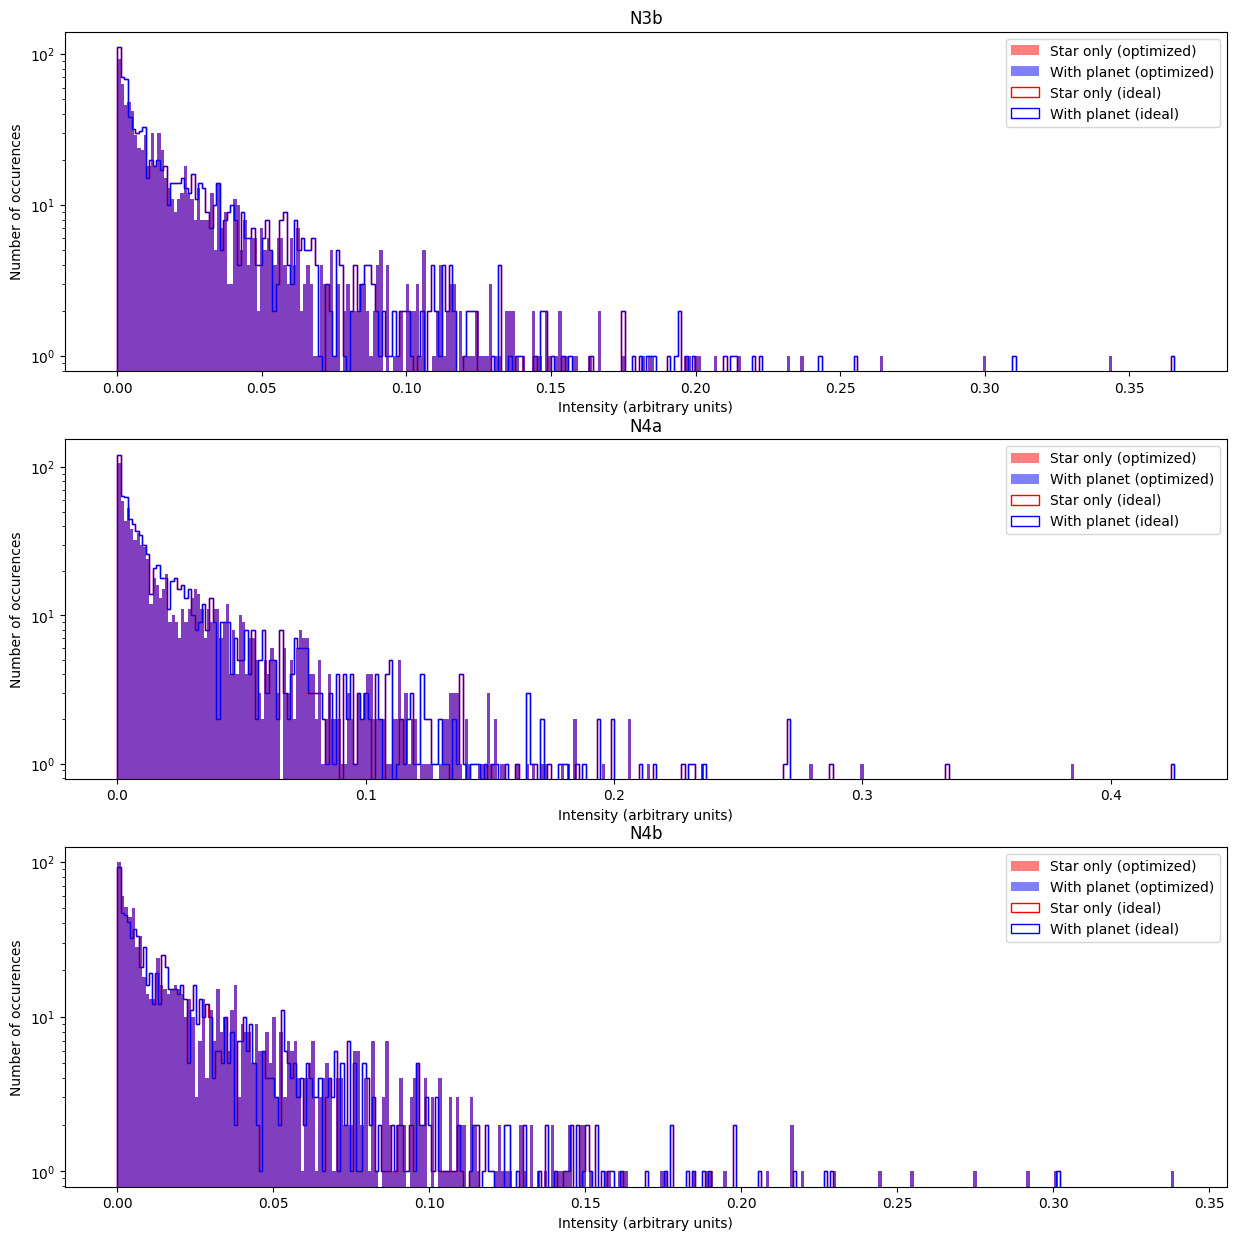

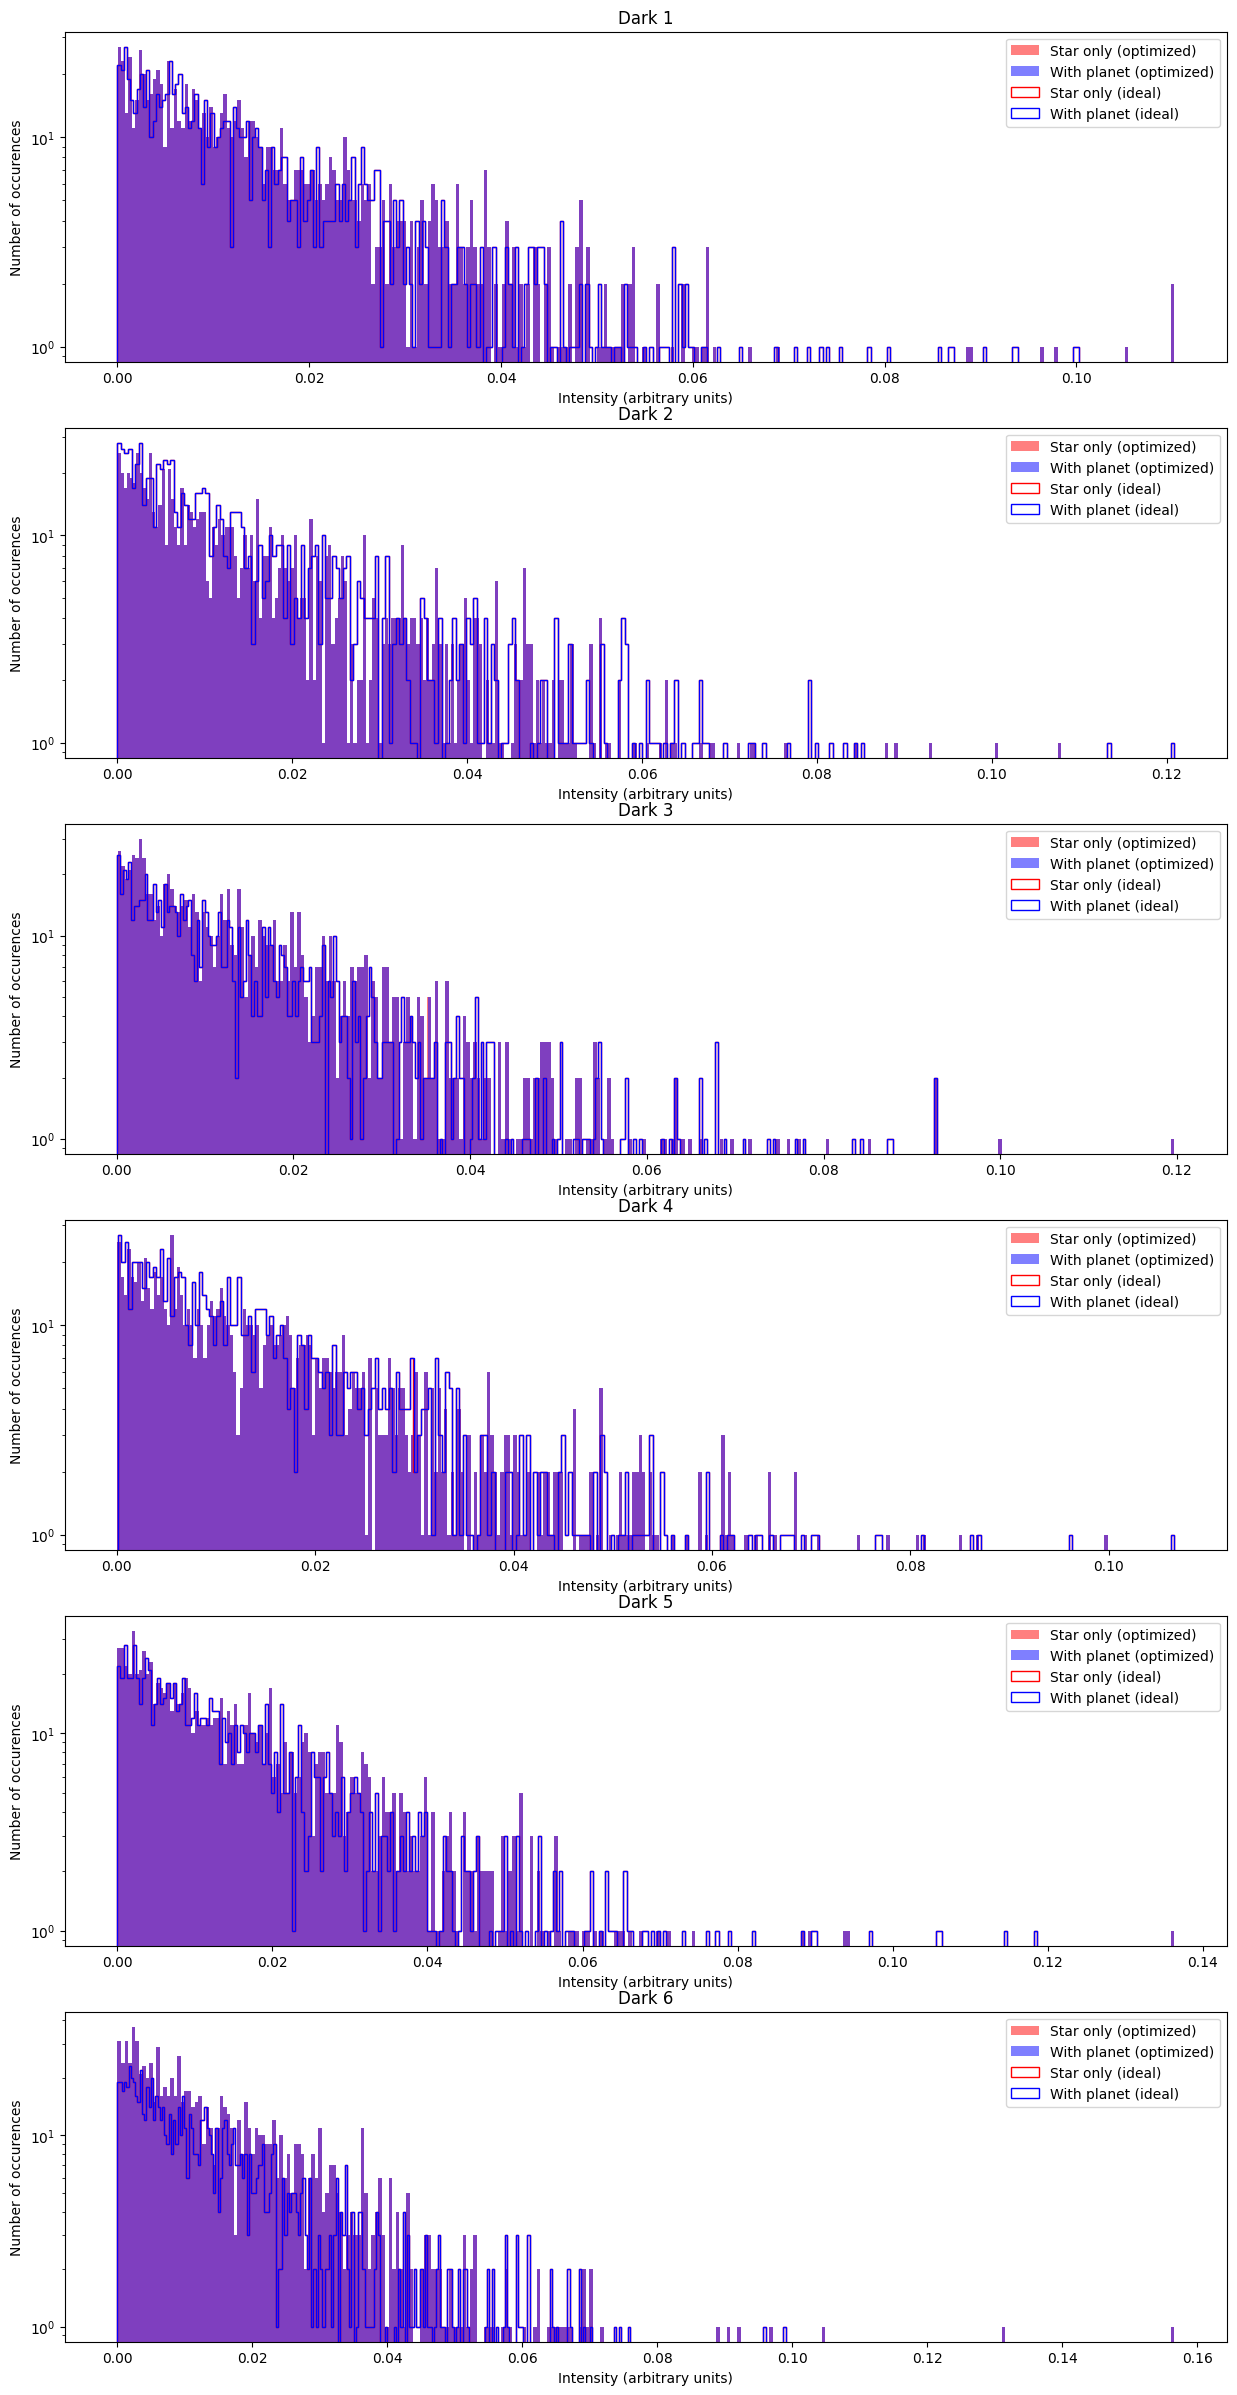

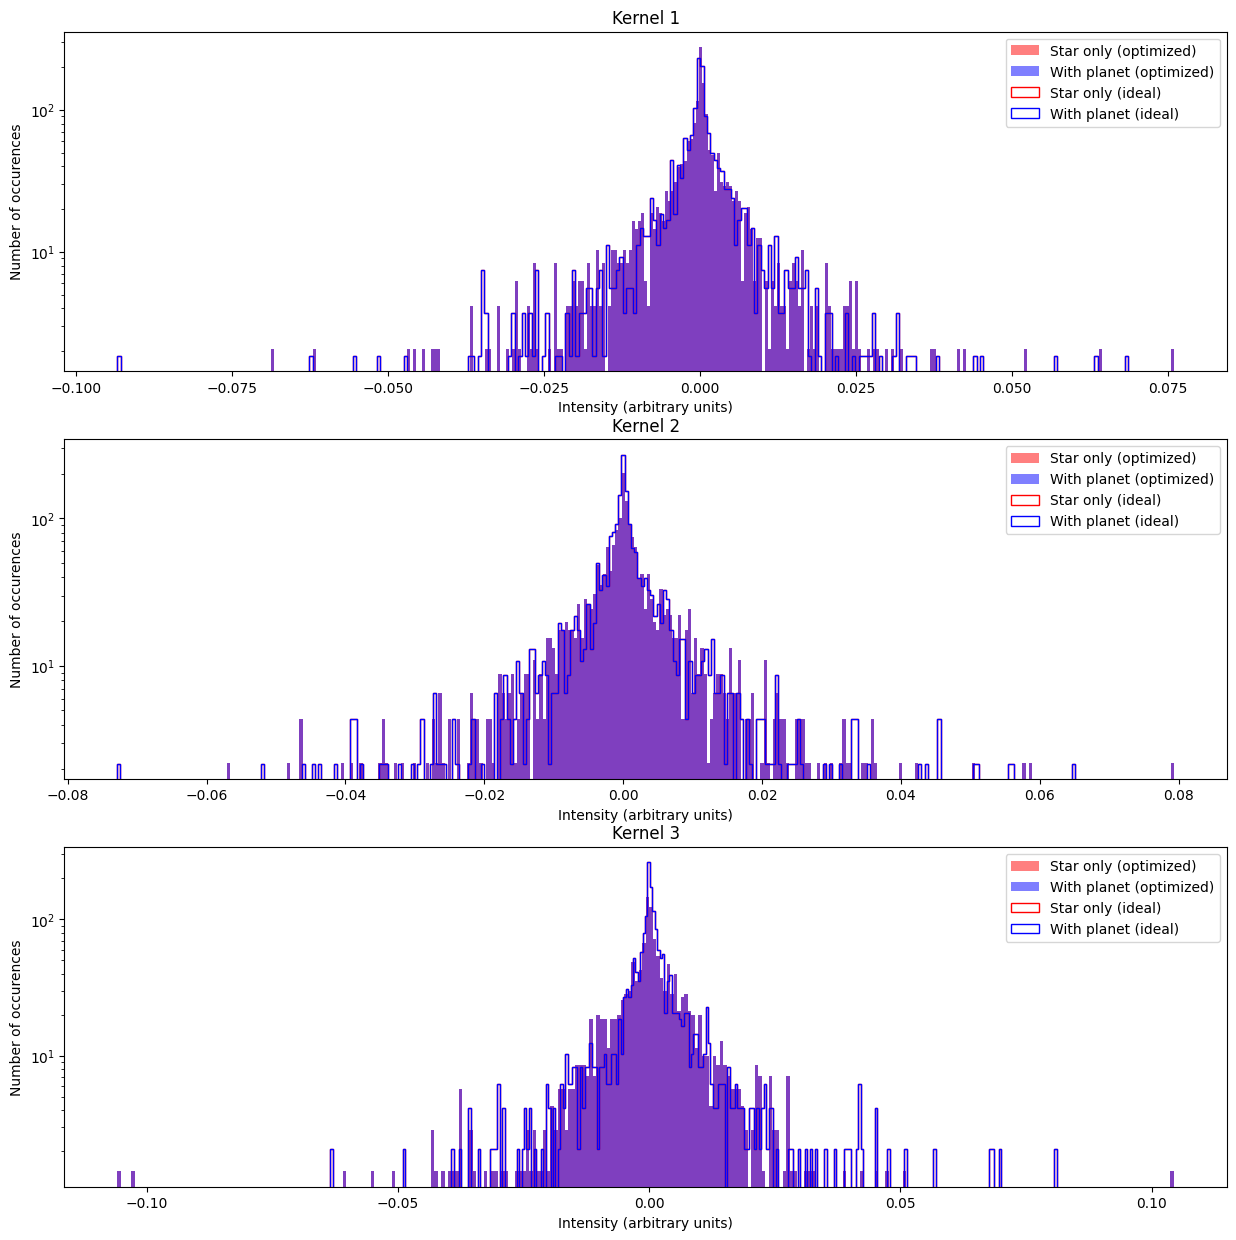

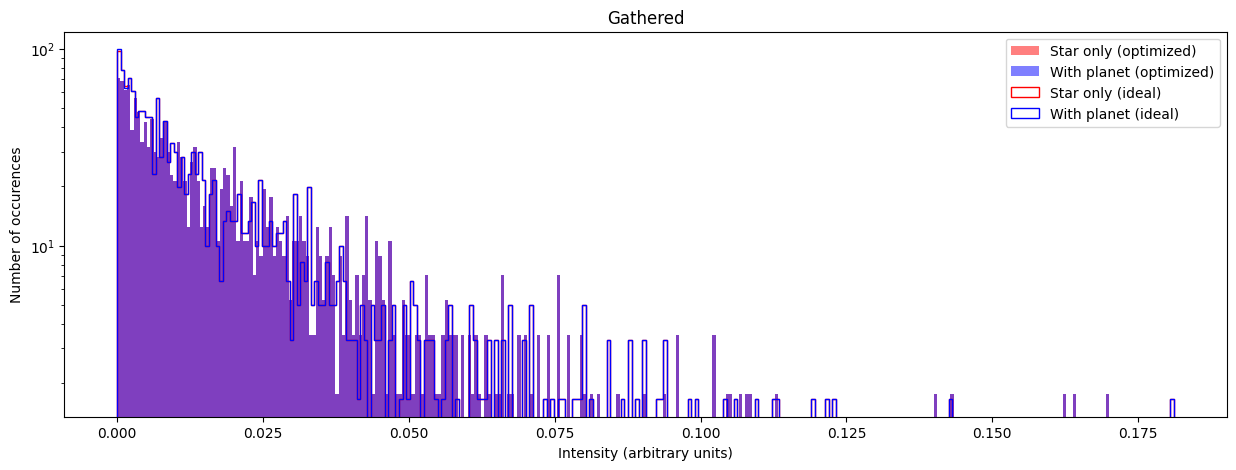

In [38]:
def plot_distributions(calibrated_dists=DIST_DATA_CALIBRATED, ideal_dists=DIST_DATA_IDEAL, perturbed_dists=DIST_DATA_PERTURBED):

    null_outputs = ['N3b', 'N4a', 'N4b']

    bins = 300

    # Nuller ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    fig, axs = plt.subplots(3, 1, figsize=(15, 15))
    for i in range(3):
        ax = axs[i]

        n1,_,_ = ax.hist(calibrated_dists['nulls_so'][i], bins=bins, color='red', label=f"Star only (optimized)", alpha = 0.5, log=True)
        n2,_,_ = ax.hist(calibrated_dists['nulls_wp'][i], bins=bins, color='blue', label=f"With planet (optimized)", alpha = 0.5, log=True)
        ax.hist(ideal_dists['nulls_so'][i], bins=bins, histtype='step', color='red', label=f"Star only (ideal)", linewidth=1, log=True)
        ax.hist(ideal_dists['nulls_wp'][i], bins=bins, histtype='step', color='blue', label=f"With planet (ideal)", linewidth=1, log=True)
        if perturbed_dists is not None:
            ax.hist(perturbed_dists['nulls_so'][i], bins=bins, histtype='step', color='orange', linestyle="dashed", label=f"Star only (perturbed)", linewidth=1, log=True)
            ax.hist(perturbed_dists['nulls_wp'][i], bins=bins, histtype='step', color='purple', linestyle="dashed", label=f"With planet (perturbed)", linewidth=1, log=True)

        ax.set_xlabel("Intensity (arbitrary units)")
        ax.set_ylabel("Number of occurences")
        ax.set_title(f"{null_outputs[i]}")
        ax.legend()

    # Dark ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
    fig, axs = plt.subplots(6, 1, figsize=(15, 30))
    for i in range(6):
        ax = axs[i]

        n1,_,_ = ax.hist(calibrated_dists['darks_so'][i], bins=bins, color='red', label=f"Star only (optimized)", alpha=0.5, log=True)
        n2,_,_ = ax.hist(np.array(calibrated_dists['darks_wp'][i]), bins=bins, color='blue', label=f"With planet (optimized)", alpha=0.5, log=True)
        ax.hist(ideal_dists['darks_so'][i], bins=bins, histtype='step', color='red', label=f"Star only (ideal)", linewidth=1, log=True)
        ax.hist(ideal_dists['darks_wp'][i], bins=bins, histtype='step', color='blue', label=f"With planet (ideal)", linewidth=1, log=True)
        if perturbed_dists is not None:
            ax.hist(perturbed_dists['darks_so'][i], bins=bins, histtype='step', color='orange', linestyle="dashed", label=f"Star only (perturbed)", linewidth=1, log=True)
            ax.hist(perturbed_dists['darks_wp'][i], bins=bins, histtype='step', color='purple', linestyle="dashed", label=f"With planet (perturbed)", linewidth=1, log=True)

        ax.set_xlabel("Intensity (arbitrary units)")
        ax.set_ylabel("Number of occurences")
        ax.set_title(f"Dark {i+1}")
        ax.legend()

    # Kernel ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

    fig, axs = plt.subplots(3, 1, figsize=(15, 15))
    for i in range(3):
        ax = axs[i]

        n1,_,_ = ax.hist(calibrated_dists['kernels_so'][i], bins=bins, color='red', label=f"Star only (optimized)", density=True, alpha=0.5, log=True)
        n2,_,_ = ax.hist(np.array(calibrated_dists['kernels_wp'][i]), bins=bins, color='blue', label=f"With planet (optimized)", density=True, alpha=0.5, log=True)
        ax.hist(ideal_dists['kernels_so'][i], bins=bins, histtype='step', color='red', label=f"Star only (ideal)", linewidth=1, density=True, log=True)
        ax.hist(ideal_dists['kernels_wp'][i], bins=bins, histtype='step', color='blue', label=f"With planet (ideal)", linewidth=1, density=True, log=True)
        if perturbed_dists is not None:
            ax.hist(perturbed_dists['kernels_so'][i], bins=bins, histtype='step', color='black', linestyle="dashed", label=f"Star only (perturbed)", linewidth=1, density=True, log=True)
            ax.hist(perturbed_dists['kernels_wp'][i], bins=bins, histtype='step', color='purple', linestyle="dashed", label=f"With planet (perturbed)", linewidth=1, density=True, log=True)

        print(f"Kernel {i+1} signal: Ideal = {np.mean(ideal_dists['kernels_wp'][i]):.2e}, Calibrated = {np.mean(calibrated_dists['kernels_wp'][i]):.2e}")

        ax.set_xlabel("Intensity (arbitrary units)")
        ax.set_ylabel("Number of occurences")
        ax.set_title(f"Kernel {i+1}")
        ax.legend()

    # Gathered ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
    _, ax = plt.subplots(1, 1, figsize=(15, 5))

    n1,_,_ = ax.hist(calibrated_dists['cumul_so'], bins=bins, color='red', label=f"Star only (optimized)", density=True, alpha=0.5, log=True)
    n2,_,_ = ax.hist(calibrated_dists['cumul_wp'], bins=bins, color='blue', label=f"With planet (optimized)", density=True, alpha=0.5, log=True)
    ax.hist(ideal_dists['cumul_so'], bins=bins, histtype='step', color='red', label=f"Star only (ideal)", linewidth=1, density=True, log=True)
    ax.hist(ideal_dists['cumul_wp'], bins=bins, histtype='step', color='blue', label=f"With planet (ideal)", linewidth=1, density=True, log=True)
    if perturbed_dists is not None:
        ax.hist(perturbed_dists['cumul_so'], bins=bins, histtype='step', color='black', linestyle="dashed", label=f"Star only (perturbed)", linewidth=1, density=True, log=True)
        ax.hist(perturbed_dists['cumul_wp'], bins=bins, histtype='step', color='purple', linestyle="dashed", label=f"With planet (perturbed)", linewidth=1, density=True, log=True)
    
    ax.set_xlabel("Intensity (arbitrary units)")
    ax.set_ylabel("Number of occurences")
    ax.set_title(f"Gathered")
    ax.legend()

    plt.show()

plot_distributions(perturbed_dists=None)

## 📢 Noise sensitivity

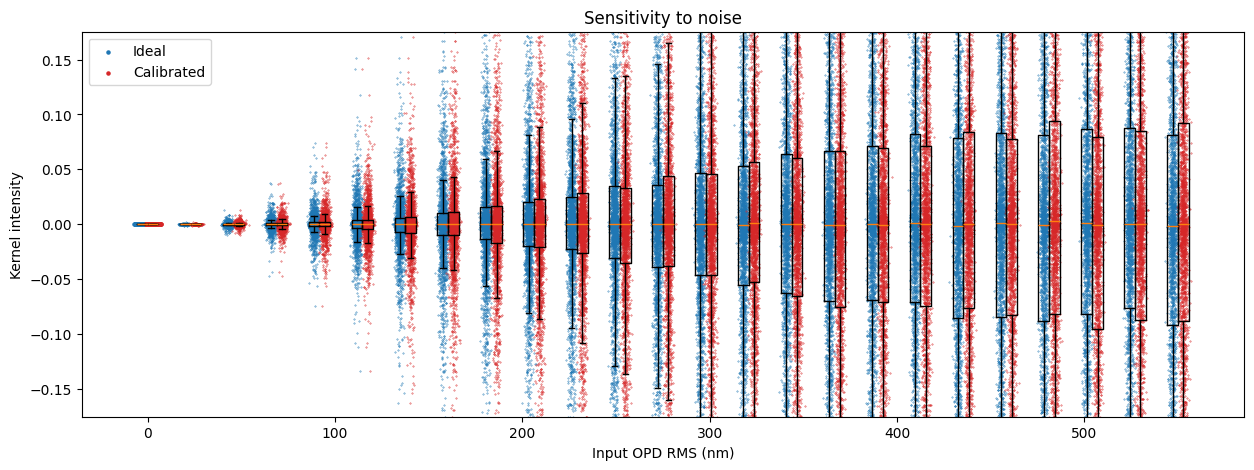

In [39]:
def plot_sensitivity_to_noise(shifts=OPTIMIZED_SHIFTS, shifts_total_opd=SHIFTS_TOTAL_OPD):

    input_ce_rms_range, step = np.linspace(0, L.value/3, 25, retstep=True)
    input_ce_rms_range = (input_ce_rms_range * L.unit).to(u.nm)
    step = (step * L.unit).to(u.nm)
    stds = []

    _, ax = plt.subplots(1, 1, figsize=(15, 5))

    for i, input_ce_rms in enumerate(input_ce_rms_range):

        dists_ideal = bulk_observation(1000, STAR_SIGNALS, np.zeros(4, dtype=np.complex128)*L.unit, np.zeros(14)*L.unit, np.zeros(14)*L.unit, input_ce_rms, L)
        dists_optimized = bulk_observation(1000, STAR_SIGNALS, np.zeros(4, dtype=np.complex128)*L.unit, shifts, shifts_total_opd, input_ce_rms, L)
        kernel_dist_ideal = np.concatenate([*dists_ideal['kernels_so']])
        kernel_dist_optimized = np.concatenate([*dists_optimized['kernels_so']])
        stds.append(np.std(kernel_dist_ideal))
        stds.append(np.std(kernel_dist_optimized))

        ax.scatter(np.random.normal(input_ce_rms.value - step.value/8, step.value/20, len(kernel_dist_ideal)), kernel_dist_ideal, color='tab:blue', s=5 if i == 0 else 0.1, alpha=1 if i==0 else 1, label="Ideal" if i == 0 else None)
        ax.scatter(np.random.normal(input_ce_rms.value + step.value/8, step.value/20, len(kernel_dist_ideal)), kernel_dist_ideal, color='tab:red', s=5 if i == 0 else 0.1, alpha=1 if i==0 else 1, label="Calibrated" if i == 0 else None)
        ax.boxplot(kernel_dist_ideal, vert=True, positions=[input_ce_rms.value - step.value/8],widths=step.value/4, showfliers=False, manage_ticks=False)
        ax.boxplot(kernel_dist_optimized, vert=True, positions=[input_ce_rms.value + step.value/8],widths=step.value/4, showfliers=False, manage_ticks=False)

    ax.set_ylim(-max(stds), max(stds))
    ax.set_xlabel(f"Input OPD RMS ({input_ce_rms_range.unit})")
    ax.set_ylabel("Kernel intensity")
    ax.set_title("Sensitivity to noise")
    ax.legend()

plot_sensitivity_to_noise()

## ☑️ Model fitting (WIP)

Distributions are cool, but in order to make deeper analysis, we want to find a model that describe these distribution using few parameters. Unfortunately, there is no straightforward way to get such model as these distribution are very particular.

The next block try most of the common distribution models and show the best ones... but unfortunately, none of them seems to match 😞

In [40]:
def fit(data):
    f = fitter.Fitter(data,
           distributions=fitter.get_distributions())
    f.fit()
    f.summary()

# fit(DIST_DATA_IDEAL['kernels_so'][0])

## 📈 Test statistics

A test statistic is a way of reducing the data we have to an unique number and compare this number to a threshold value. If the number is below the treshold, then the null hypothesis is favored. If it is above, the alternative hypothesis is favored. The goal is to find the best test statistic that allow to distinguish both hypothesis in a correct way

- $H0$: the null hypothesis -> there is no planet
- $H1$: the alternative hypothesis -> there is a planet

- $T0$: vector of distributions obtained with H0
- $T1$: vector of distributions obtained with H1

In [41]:
@nb.njit()
def get_distrib_vectors(Nmc, size):
    T0 = np.zeros((3, Nmc,size))
    T1 = np.zeros((3, Nmc,size))
    for i in range(Nmc):
        dists = bulk_observation_jitted(size)
        for k in range(3):
            T0[k,i] = dists[4][k]
            T1[k,i] = dists[5][k]
    return T0, T1

T0, T1 = get_distrib_vectors(100, 1000)

### Mean

**Principle:** We take the average of the distribution and we compare it to a treshold.

$$
\left|\frac{1}{N}\sum_i x_i \right| \stackrel{H_1}{\underset{H_0}{\gtrless}} \xi
$$

In [42]:
def ts_mean(data):
    return np.abs(np.mean(data, axis=1))

### Median

**Principle:** We take the median of the distribution and we compare it to a treshold.

$$
\begin{cases}
\left| x_{\frac{N+1}{2}} \right| & \text{if }N\text{ is odd} \\

\left| \frac{x_{\frac{N}{2}} + x_{\frac{N+1}{2}}}{2} \right|  & \text{if }N\text{ is odd}
\end{cases}
\quad\stackrel{H_1}{\underset{H_0}{\gtrless}} \xi
$$

In [43]:
def ts_median(data):
    return np.abs(np.median(data, axis=1))

### Argmax

**Principle:** We pack our data in bins and we consider the position of the bin with the highest number of occurences. We compare it to a treshold.

In [44]:
def ts_argmax(data, bins=100):
    maxs = np.zeros(data.shape[0])
    for i, dist in enumerate(data):
        hist = np.histogram(dist, bins=bins)
        maxs[i] = hist[1][np.argmax(hist[0])]
    return np.abs(maxs)

def ts_argmax50(data):
    return ts_argmax(data, 50)

def ts_argmax100(data):
    return ts_argmax(data, 100)

def ts_argmax500(data):
    return ts_argmax(data, 500)

### Kolmogorov-Smirnov

**Principle:** We compare the maximum distance on the cumulative distribution functions of the two distributions.

In [45]:
def ts_kolmogorov_smirnov(data):

    distances = np.zeros(data.shape[0])

    for d, dist in enumerate(data):

        ref_dist = DIST_DATA_CALIBRATED['kernels_so'][0]

        dist = np.sort(dist)
        ref_dist = np.sort(ref_dist)

        v = np.min(np.concatenate([dist, ref_dist]))

        i_ref = 0
        i_dist = 0

        count_ref = 0
        count_dist = 0

        while i_ref < len(ref_dist) and i_dist < len(dist):

            if ref_dist[i_ref] < dist[i_dist]:
                count_ref += 1
                i_ref += 1
            else:
                count_dist += 1
                i_dist += 1
            
            distances[d] = max(distances[d], np.abs(count_dist - count_ref) )#/ len(reference))

    return distances

### Cramèr-von Mises

**Principle:** We compare the total quadratique distance on the cumulative distribution functions of the two distributions.

In [46]:
def ts_cramer_von_mises(data):

    distances = np.zeros(data.shape[0])

    for d, dist in enumerate(data):

        ref_dist = DIST_DATA_CALIBRATED['kernels_so'][0]

        dist = np.sort(dist)
        ref_dist = np.sort(ref_dist)

        v = np.min(np.concatenate([dist, ref_dist]))

        i_ref = 0
        i_dist = 0

        count_ref = 0
        count_dist = 0

        while i_ref < len(ref_dist) and i_dist < len(dist):

            if ref_dist[i_ref] < dist[i_dist]:
                count_ref += 1
                i_ref += 1
            else:
                count_dist += 1
                i_dist += 1
            
            distances[d] += np.abs(count_dist - count_ref) ** 2

    return distances


### Wilcoxon-Mann-Whitney (WIP)

In [47]:
def ts_wilcoxon_mann_whitney(data):

    res = np.empty(len(data))

    ref_dist = DIST_DATA_CALIBRATED['kernels_so'][0]

    for d, dist in enumerate(data):

        sorted_comb = np.unique(np.sort(np.concatenate([dist, ref_dist])))

        r1 = np.sum(np.searchsorted(sorted_comb, dist) + 1)
        r2 = np.sum(np.searchsorted(sorted_comb, ref_dist) + 1)

        n1 = len(dist)
        n2 = len(ref_dist)

        u1 = n1*n2 + n1*(n1+1)/2 - r1
        u2 = n1*n2 + n2*(n2+1)/2 - r2

        res[d] = min(u1, u2)
    
    return res

In [48]:
def ts_cdf_diff_area(data):
    """
    Compute the area between the 2 CDF 
    """
    #data
    num_simulations = data.shape[0]
    distances = np.zeros(num_simulations)
    
    ref_dist = DIST_DATA_CALIBRATED['kernels_so'][0]
    ref_dist_sorted = np.sort(ref_dist)
    m = len(ref_dist_sorted)
    cdf_ref_dist = np.arange(1, m + 1) / m

    for d in range(num_simulations):
        dist = data[d, :]
        dist = np.sort(dist)
        n = len(dist)
        cdf_dist = np.arange(1, n + 1) / n

        #interpolation 
        cdf_ref_dist_interp = np.interp(dist, ref_dist_sorted, cdf_ref_dist)

        #test 
        cdf_diff = cdf_dist - cdf_ref_dist_interp
        area = np.trapz(cdf_diff, dist)
        distances[d] = area
    
    return distances

In [49]:
TEST_STATISTICS = {
    'Mean': ts_mean,
    'Median': ts_median,
    # 'argmax50': ts_argmax50,
    # 'argmax100': ts_argmax100,
    # 'Argmax500': ts_argmax500,
    'Kolmogorov-Smirnov': ts_kolmogorov_smirnov,
    'Cramer Von Mises': ts_cramer_von_mises,
    'Wilcoxon Mann Whitney': ts_wilcoxon_mann_whitney,
    'CDF Diff. Area': ts_cdf_diff_area
}

## ❓ ROC curves

ROC curves allow to compare the power of different test statistics. It show the proportion of true detection in function of the probability of false alarm. The more the curve climb fast, the better it is.

In [50]:
def roc(T0, T1, test_statistic, multiple_source=False):

    N = len(T0)

    # Computing test statistic of all the distributions
    if not multiple_source: 
        T0_values = test_statistic(T0)
        T1_values = test_statistic(T1)
    else:
        T0_values = np.zeros(T0.shape[1])
        T1_values = np.zeros(T0.shape[1])
        for i in range(len(T0)):
            T0_values += test_statistic(T0[i])
            T1_values += test_statistic(T1[i])

    # Computng the maximum treshold value
    sup = np.max(np.concatenate([T0_values, T1_values]))

    thresholds = np.linspace(0, sup, 1000)
    
    Pfa = np.zeros(len(thresholds))
    Pdet = np.zeros(len(thresholds))
    for i, threshold in enumerate(thresholds):
        Pfa[i] = np.sum(T0_values > threshold) / N
        Pdet[i] = np.sum(T1_values > threshold) / N

    return Pfa, Pdet, thresholds

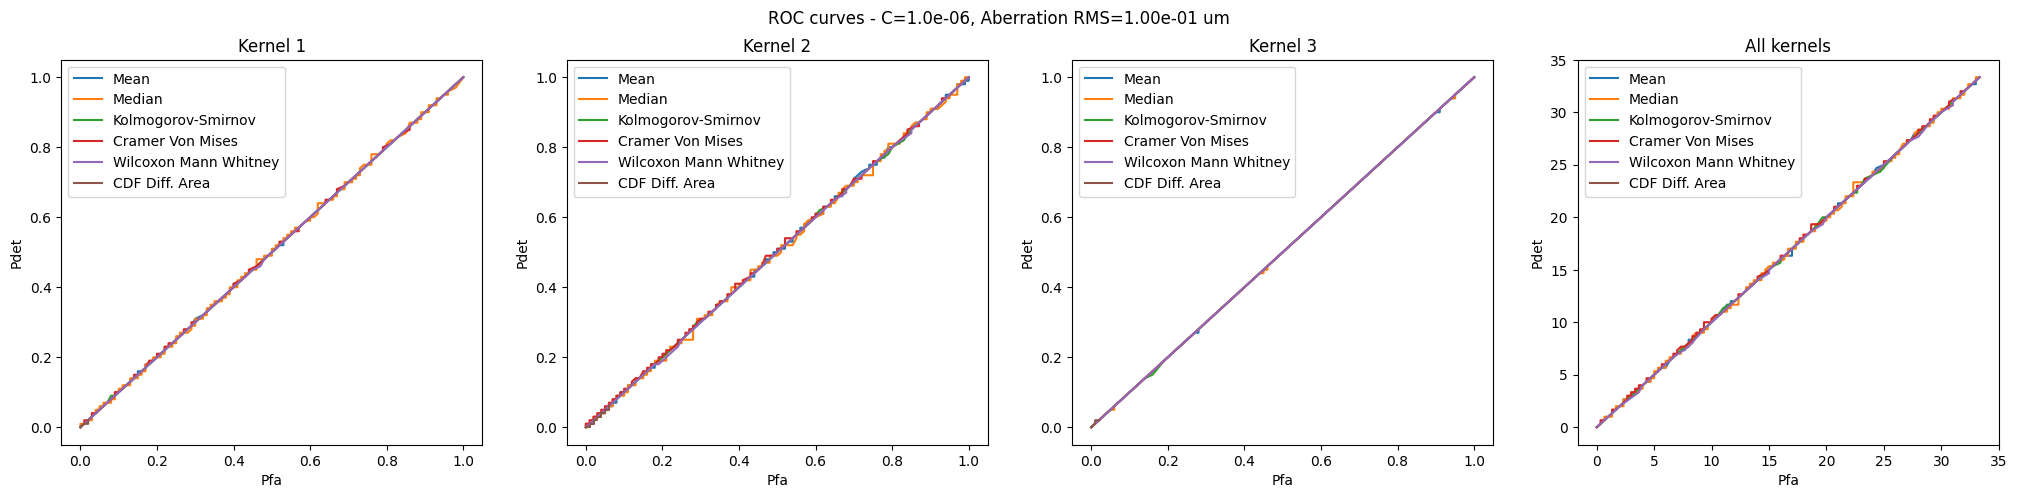

In [51]:
def plot_roc(test_statistics = TEST_STATISTICS):

    _, axs = plt.subplots(1, 4, figsize=(25, 5))

    for k in range(4):
        for ts_name, ts in test_statistics.items():
            if k < 3:
                Pfa, Pdet, _ = roc(T0[k], T1[k], ts)
                axs[k].set_title(f"Kernel {k+1}")
            else:
                Pfa, Pdet, _ = roc(T0, T1, ts, multiple_source=True)
                axs[k].set_title(f"All kernels")
            axs[k].plot(Pfa, Pdet, label=ts_name)
            axs[k].set_xlabel("Pfa")
            axs[k].set_ylabel("Pdet")
            axs[k].legend()

    plt.suptitle(f"ROC curves - C={CONTRAST:.1e}, Aberration RMS={INPUT_CE_RMS:.2e}")
    plt.show()

plot_roc()

## 💪 P-values

The P-value is an indicator of the confidence we have to reject the null hypothesis.

The principle consist in comparing the test statistic obtain on the data we want to test with a large bunch of data that we know to be under the null hypothesis. We then compute the proportion of test statistic that are above the one we obtained. This proportion is the P-value.

Thus, the lower the P-value, the more confident we are to reject the null hypothesis. A P-value below 0.05 is commonly considered as a good indicator to reject the null hypothesis.

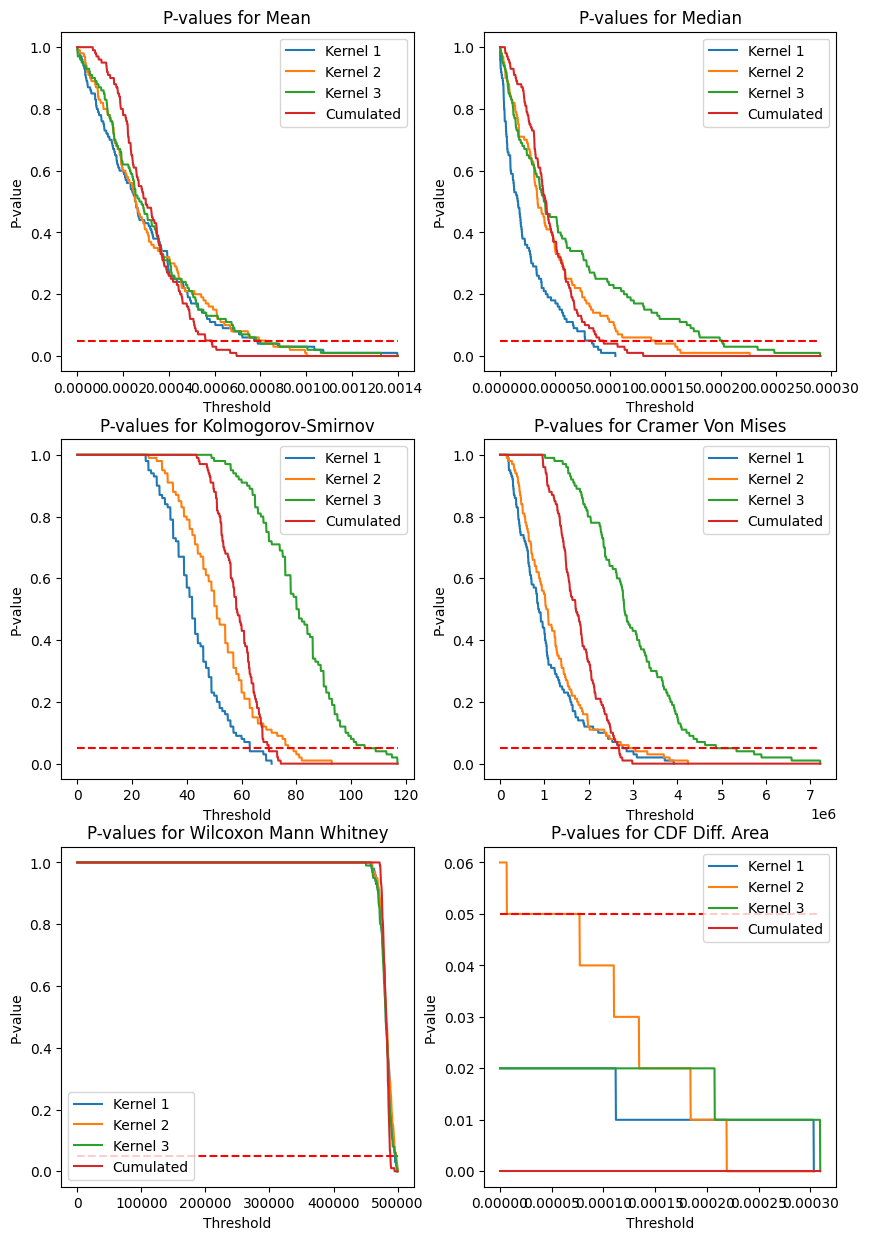

In [52]:
def plot_p_values(test_statistics = TEST_STATISTICS):

    col = min(2, len(test_statistics))
    row = int(np.ceil(len(test_statistics) / col))

    _, axs = plt.subplots(row, col, figsize=(5*col, 5*row))
    axs = axs.flatten()
    
    t = 0
    for ts_name, ts in test_statistics.items():
        cumulated_values = np.zeros(T0.shape[1])
        sup = 0
        for k in range(4):
            if k < 3:
                values = ts(T0[k])
                cumulated_values += values / 3
                label = f"Kernel {k+1}"
            elif k == 3:
                values = cumulated_values
                label = "Cumulated"
            sup = max(sup, np.max(values))
            thresholds = np.linspace(0, sup, 1000)
            p_values = np.zeros(len(thresholds))
            for i, threshold in enumerate(thresholds):
                p_values[i] = np.sum(values > threshold) / len(values)
            axs[t].plot(thresholds, p_values, label=label)
        axs[t].hlines(0.05, 0, sup, color='red', linestyle='dashed')
        axs[t].set_xlabel("Threshold")
        axs[t].set_ylabel("P-value")
        axs[t].set_title(f"P-values for {ts_name}")
        axs[t].legend()
        t+=1
    plt.show()

plot_p_values()

---

<div align=center>

# 🪐 **Characterization**

</div>

## 🔄️ Angular diversity

In order to determine the planet position, we need to rotate the interferometer baseline in order to rotate the transmission map. Thus, the planet signal will be modulated. By analysis this modulation (trying to fit the parametrized modulation function to the data points), it is possible to retrieve the planet position.

In [53]:
def kernels_modulation_njit(
    alpha_range:np.ndarray[float]=ALPHA_RANGE.to(u.rad).value,
    alpha:float=ALPHA.to(u.rad).value,
    theta:float=THETA.to(u.rad).value,
    contrast:float=CONTRAST
) -> np.ndarray[float]:
    """
    Compute the modulation of the kernels with respect to the phase shifters

    Parameters
    ----------
    - alpha_range: The range of alpha values to consider.
    - initial_alpha: The initial alpha value.
    - theta: The theta value.
    - contrast: The contrast value.

    Returns
    -------
    - The modulation of the kernels.
    """

    light = np.sqrt(contrast) + 0j

    kernels_mod = np.zeros((3, len(alpha_range)))
    for a, delta_alpha in enumerate(alpha_range):

        signals = acquire_signals_njit(
            amplitude=light, angular_separation=theta, alpha=alpha+delta_alpha
        )

        _, _, kernels, _ = kn_njit(
            signals,
            shifts=np.zeros(14),
            shifts_total_opd=np.zeros(14),
        )

        for i in range(3):
            kernels_mod[i, a] = kernels[i]

    return np.array(kernels_mod)

def kernels_modulation(
    alpha_range:u.Quantity=ALPHA_RANGE,
    alpha:u.Quantity=ALPHA,
    theta:u.Quantity=THETA,
    contrast:float=CONTRAST
):
    return kernels_modulation_njit(alpha_range.to(u.rad).value, alpha.to(u.rad).value, theta.to(u.rad).value, contrast)


def kernel1_modulation_njit(
    alpha_range=ALPHA_RANGE, alpha=ALPHA, theta=THETA, contrast=CONTRAST
):
    return kernels_modulation_njit(alpha_range, alpha, theta, contrast)[0]

def kernel2_modulation_njit(
    alpha_range=ALPHA_RANGE, alpha=ALPHA, theta=THETA, contrast=CONTRAST
):
    return kernels_modulation_njit(alpha_range, alpha, theta, contrast)[1]

def kernel3_modulation_njit(
    alpha_range=ALPHA_RANGE, alpha=ALPHA, theta=THETA, contrast=CONTRAST
):
    return kernels_modulation_njit(alpha_range, alpha, theta, contrast)[2]


kernelk_modulation = [kernel1_modulation_njit, kernel2_modulation_njit, kernel3_modulation_njit]

Param    = Ideal | First guess | Found
Alpha    = 70.00 deg | 52.04 deg | 58.18 deg
Theta    = 7.00 mas | 7.54 mas | 8.71 mas
Contrast = 1.00e-06 | 7.37e-07 | 1.75e-05
---
Alpha    = 70.00 deg | 64.48 deg | 104.89 deg
Theta    = 7.00 mas | 6.92 mas | 23.95 mas
Contrast = 1.00e-06 | 1.16e-06 | 2.04e-05
---


C:\Users\vforiel\AppData\Local\Temp\ipykernel_20664\2600112200.py:22: RuntimeWarning: invalid value encountered in sqrt
  light = np.sqrt(contrast) + 0j


Alpha    = 70.00 deg | 54.24 deg | 56.36 deg
Theta    = 7.00 mas | 6.87 mas | 8.62 mas
Contrast = 1.00e-06 | 8.13e-07 | 1.04e-11
---


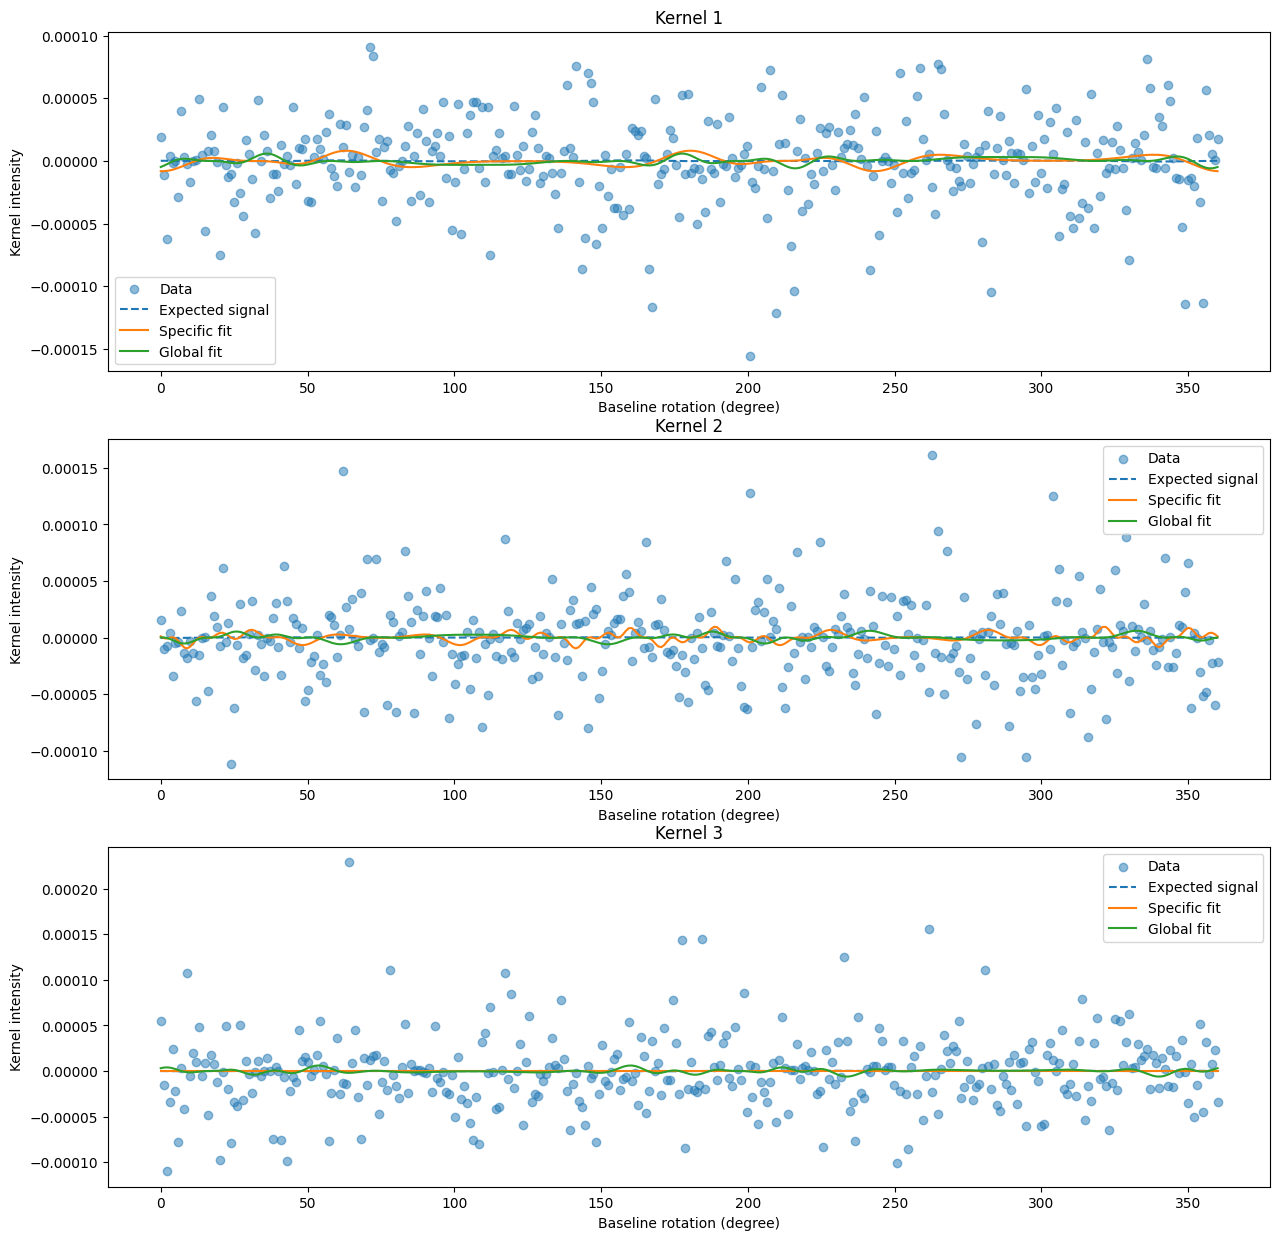

Param    = Ideal | Found
Alpha    = 70.00 deg | 73.14 deg
Theta    = 7.00 mas | 13.76 mas
Contrast = 1.00e-06 | 1.26e-05


In [54]:
def plot_angular_diversity(
        data=PARALLACTIC_DIVERSITY_DATA,
        alpha_range=ALPHA_RANGE,
    ):

    fits = np.zeros((3, len(alpha_range)))

    print("Param    = Ideal | First guess | Found")
    print("======================================")

    popts = []
    for i in range(3):
        # Fit data to kernels modulations
        p0 = [ALPHA.value + np.random.normal(0,0.1*np.pi), (THETA + np.random.normal(0,0.2)*u.mas).to(u.rad).value, CONTRAST * np.random.normal(1,0.3)]
        
        popt, pcov = curve_fit(
            kernelk_modulation[i],
            alpha_range.value,
            data[i],
            p0=p0,
            maxfev=10000
        )

        print(f"Alpha    = {ALPHA.to(u.deg):.2f} | {(p0[0]*u.rad).to(u.deg):.2f} | {(popt[0]*u.rad).to(u.deg):.2f}")
        print(f"Theta    = {THETA.to(u.mas):.2f} | {(p0[1]*u.rad).to(u.mas):.2f} | {(popt[1]*u.rad).to(u.mas):.2f}")
        print(f"Contrast = {CONTRAST:.2e} | {p0[2]:.2e} | {popt[2]:.2e}")
        print("---")
        popts.append(popt)
    popt = np.mean(popts, axis=0)

    _, axs = plt.subplots(3, 1, figsize=(15, 15))
    for i in range(3):
        fits[i] = kernels_modulation_njit(alpha_range.to(u.rad).value, *popt)[i]

        ax = axs[i]

        ax.scatter(alpha_range.to(u.deg), data[i], label="Data",alpha=0.5)
        ax.plot(alpha_range.to(u.deg), kernels_modulation_njit(alpha_range.to(u.rad).value, contrast=CONTRAST)[i], "--", label="Expected signal")
        ax.plot(alpha_range.to(u.deg), kernels_modulation_njit(alpha_range.to(u.rad).value, *popts[i])[i], label="Specific fit")
        ax.plot(alpha_range.to(u.deg), fits[i], label="Global fit")

        ax.set_xlabel("Baseline rotation (degree)")
        ax.set_ylabel("Kernel intensity")
        ax.set_title(f"Kernel {i+1}")
        ax.legend()

    plt.show()

    print("Param    = Ideal | Found")
    print("========================")
    print(f"Alpha    = {ALPHA.to(u.deg):.2f} | {(popt[0]*u.rad).to(u.deg):.2f}")
    print(f"Theta    = {THETA.to(u.mas):.2f} | {(popt[1]*u.rad).to(u.mas):.2f}")
    print(f"Contrast = {CONTRAST:.2e} | {popt[2]:.2e}")

plot_angular_diversity()

## 🌌 On-sky contribution

From the obtained data, it is possible to build a 2D distribution of the perceived sky contribution zones. This distribution provides insights into the possible locations of objects, enabling accurate initial estimations to fit the data points obtained based on the parallactic angle.

This method involves stacking the transmission maps rotated by the baseline rotation and weighting each map by the corresponding data obtained for that baseline rotation.

The base idea was already explored as "image reconstruction" technic using classical nulling interferometry $^1$. However, the method here is based on Kernel-Nulls which makes it more complex but less sensitive to phase aberations and by considerig the different Kernels, we can reduce the degeneracy of the solutions.

Considering:
- $T_{n}$ represents the n-th kernel's normalized transmission map.
- $d_{n,\beta}$ denotes the data point obtained for kernel $n$ with baseline rotation $\beta$.
- $\alpha$ is the parallactic angle.
- $\theta$ is the angular separation.

Raw Kernel contribution zone:

$$
r_n(\theta, \alpha) = \sum_a T_n(\theta,\alpha+a) d_{n,a}
$$

Raw total contribution zone:

$$
R(\theta, \alpha) = \sum_{n}r_n
$$

Heaviside filter (if a position is negative on one of the kernel raw contribution zone, it is set to 0 to the final contribution zones)
$$
H(\theta, \alpha) = \frac{1}{2\text{max}(r_n)}\prod_n(r_n+|r_n|)
$$

Final contribution zone:
$$
C(\theta, \alpha) = R \times H
$$

**References:**
1. Angel, J. R. P., et N. J. Woolf. "An Imaging Nulling Interferometer to Study Extrasolar Planets". *The Astrophysical Journal* 475, no 1 (1997): 373‑79. https://doi.org/10.1086/303529.

Kernel 1 : 5.03e+05 / 1.53e+03 = 3.29e+02
Kernel 2 : 4.92e+05 / 1.66e+03 = 2.96e+02
Kernel 3 : 4.63e+05 / 1.54e+03 = 3.02e+02


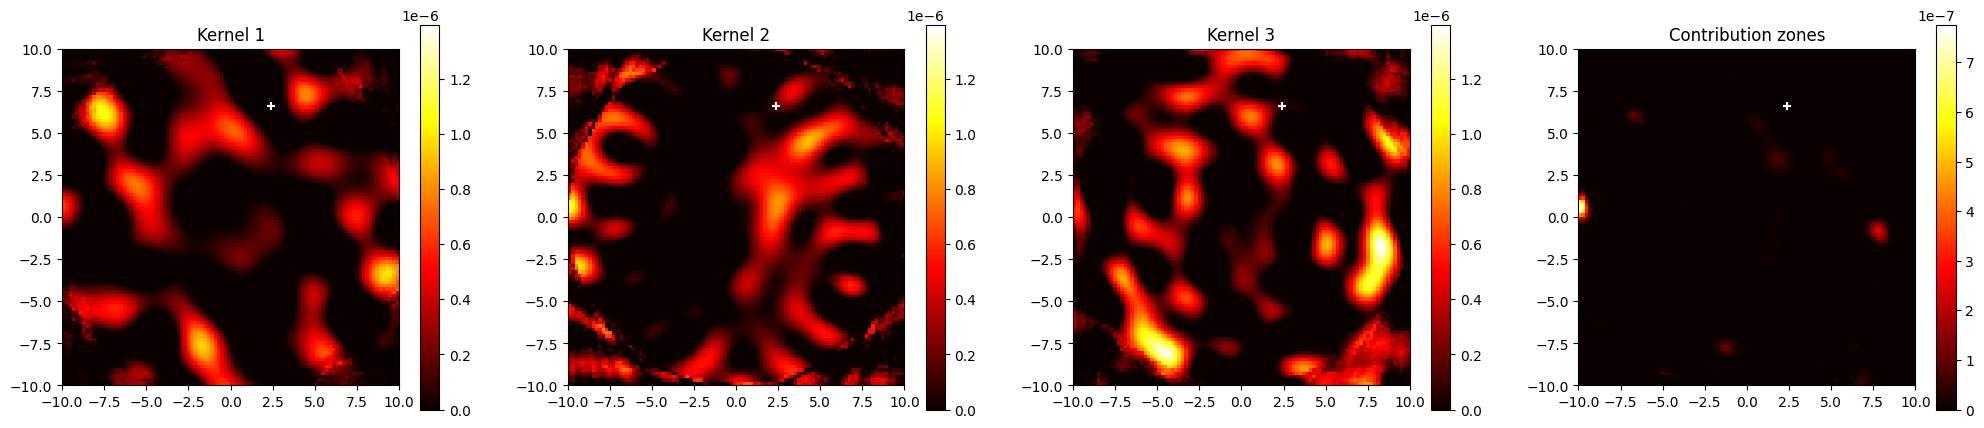

In [55]:
def plot_image_reconstruction(
    data: np.ndarray[float] = PARALLACTIC_DIVERSITY_DATA,
    fov: u.Quantity = FOV,
    resolution: int = 100,
):

    images = np.zeros((3, resolution, resolution))
    integrated_kernels = np.zeros((3, resolution, resolution))

    _, _, theta_map, _ = get_uv_map(resolution=resolution, fov=fov)
    _, _, kernel_maps = get_transmission_map(resolution=resolution)
    theta_map = theta_map.value / np.max(theta_map.value)

    for i, alpha in enumerate(np.linspace(0,2*np.pi,data.shape[1])*u.rad):

        for j in range(3):
            tm = rotate(kernel_maps[j], angle=alpha, reshape=False)
            integrated_kernels[j] += np.abs(tm) #* theta_map
            images[j] += tm * data[j, i] #* theta_map

    for i in range(3):
        integrated_kernel_intensity = np.sum(integrated_kernels[i])
        kernel_intensity = np.sum(np.abs(kernel_maps[i]))

        normalization_factor = integrated_kernel_intensity / kernel_intensity

        print(f"Kernel {i+1} : {integrated_kernel_intensity:.2e} / {kernel_intensity:.2e} = {normalization_factor:.2e}")

        images[i] /= normalization_factor

    max_im = np.max(images)

    _, axs = plt.subplots(1, 4, figsize=(25, 5))

    planet_x, planet_y = alpha_theta_to_fov_map_coord()

    for i in range(3):
        img = images[i]
        img[img < 0] = 0
        im = axs[i].imshow(img, cmap="hot", vmax=max_im, extent=EXTENT)
        axs[i].set_title(f"Kernel {i+1}")
        plt.colorbar(im, ax=axs[i])
        axs[i].scatter(planet_x, planet_y, marker="+", color="white")

    # Take mean of probable input flux
    img = np.mean(images, axis=0)

    # Filter where a probability of flux is null on one of the kernels
    images[images < 0] = 0
    mask = np.prod(images, axis=0)
    img = img * mask / np.max(mask)

    # Plot reconstructed image
    im = axs[3].imshow(img, cmap="hot", extent=EXTENT)
    axs[3].set_title("Contribution zones")
    plt.colorbar(im, ax=axs[3])
    axs[3].scatter(planet_x, planet_y, marker="+", color="white")

    plt.show()

plot_image_reconstruction()

## ♒ Correlation map (WIP)

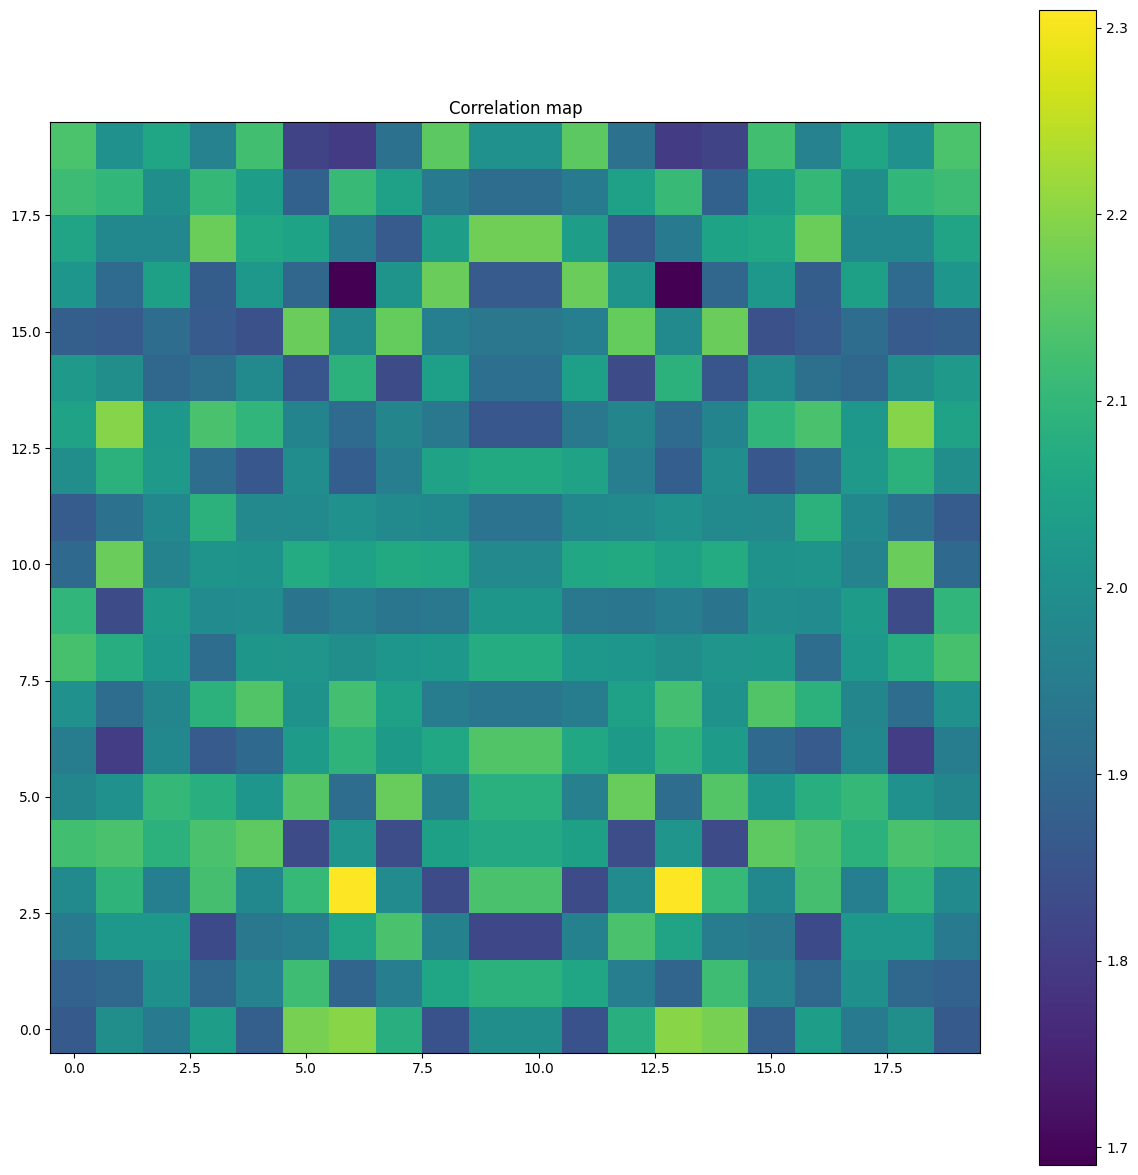

In [56]:
def correlation_map(
        data=PARALLACTIC_DIVERSITY_DATA,
        alpha_range=ALPHA_RANGE,
    ):

    resolution = 20
    
    _, _, alpha_map, theta_map = get_uv_map(resolution=resolution)

    correl_map = np.zeros((resolution, resolution))

    for x in range(resolution):
        for y in range(resolution):

            alpha = alpha_map[x, y]
            theta = theta_map[x, y]

            km = kernels_modulation(alpha_range, contrast=CONTRAST, alpha=alpha, theta=theta)[0]

            correl_map[x, y] = np.sum(np.corrcoef(data[0], km))


    _, ax = plt.subplots(1, 1, figsize=(15, 15))
    im = ax.imshow(correl_map)
    plt.colorbar(im, ax=ax)
    ax.set_title("Correlation map")

    plt.show()

correlation_map()